In [ ]:
%run MUSE_spaxel_fit.py FCC219

In [ ]:
%whos
%who_ls


## Start Here

In [1]:
gal_name = "FCC219"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy.wcs import WCS, utils, wcs
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
from photutils import CircularAperture
from IPython.display import display
from MUSE_Models import PNe_residuals_3D, PNe_spectrum_extractor, PNextractor, PSF_residuals_3D, data_cube_y_x, robust_sigma
from PNLF import open_data, reconstructed_image, completeness
import yaml
import sep
from photutils import CircularAperture
import scipy as sp
from scipy.stats import norm
from scipy import stats
from ppxf_gal_L import ppxf_L_tot
from astroquery.vizier import Vizier

# look into Pandas_profiling and cufflinks

%config InlineBackend.figure_format = 'retina'

In [3]:
# functions
# Open Fits file and assign to raw_data

hdulist = fits.open(gal_name+"_data/"+gal_name+"_residuals_list.fits")
hdr = hdulist[0].header
wavelength = np.exp(hdulist[1].data)

if gal_name == "FCC219" or gal_name =="FCC193" or gal_name =="FCC083":
    x_data, y_data, n_data = data_cube_y_x(len(hdulist[0].data))
elif gal_name == "FCC161":
    y_data, x_data = 451, 736
elif gal_name=="FCC184":
    x_data, y_data = 1077, 566
else:
    y_data, x_data, n_data = data_cube_y_x(len(hdulist[0].data))
    
    
n_pixels = 9    # minicube FOV in pixels
c = 299792458.0 # speed of light

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])


def progbar(curr, total, full_progbar):
    frac = curr/total
    filled_progbar = round(frac*full_progbar)
    print('\r', '#'*filled_progbar + '-'*(full_progbar-filled_progbar), '[{:>7.2%}]'.format(frac), str(curr)+"/"+ str(total), end='')

# Load in data and plot FOV

In [4]:
# Pull out the 1D flux data from 1D fits to do radial comparison

gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)

#PNe_1D_flux_data = np.array([PNextractor(x, y, n_pixels, Flux_1D_cube, dim=1.0) for x,y in zip(x_PNe,y_PNe)])
#PNe_1D_A_rN_data = np.array([PNextractor(x, y, n_pixels, A_rN_plot_shape, dim=1.0) for x,y in zip(x_PNe,y_PNe)])

# SEP - Source Detection

90


<Figure size 1440x1440 with 0 Axes>

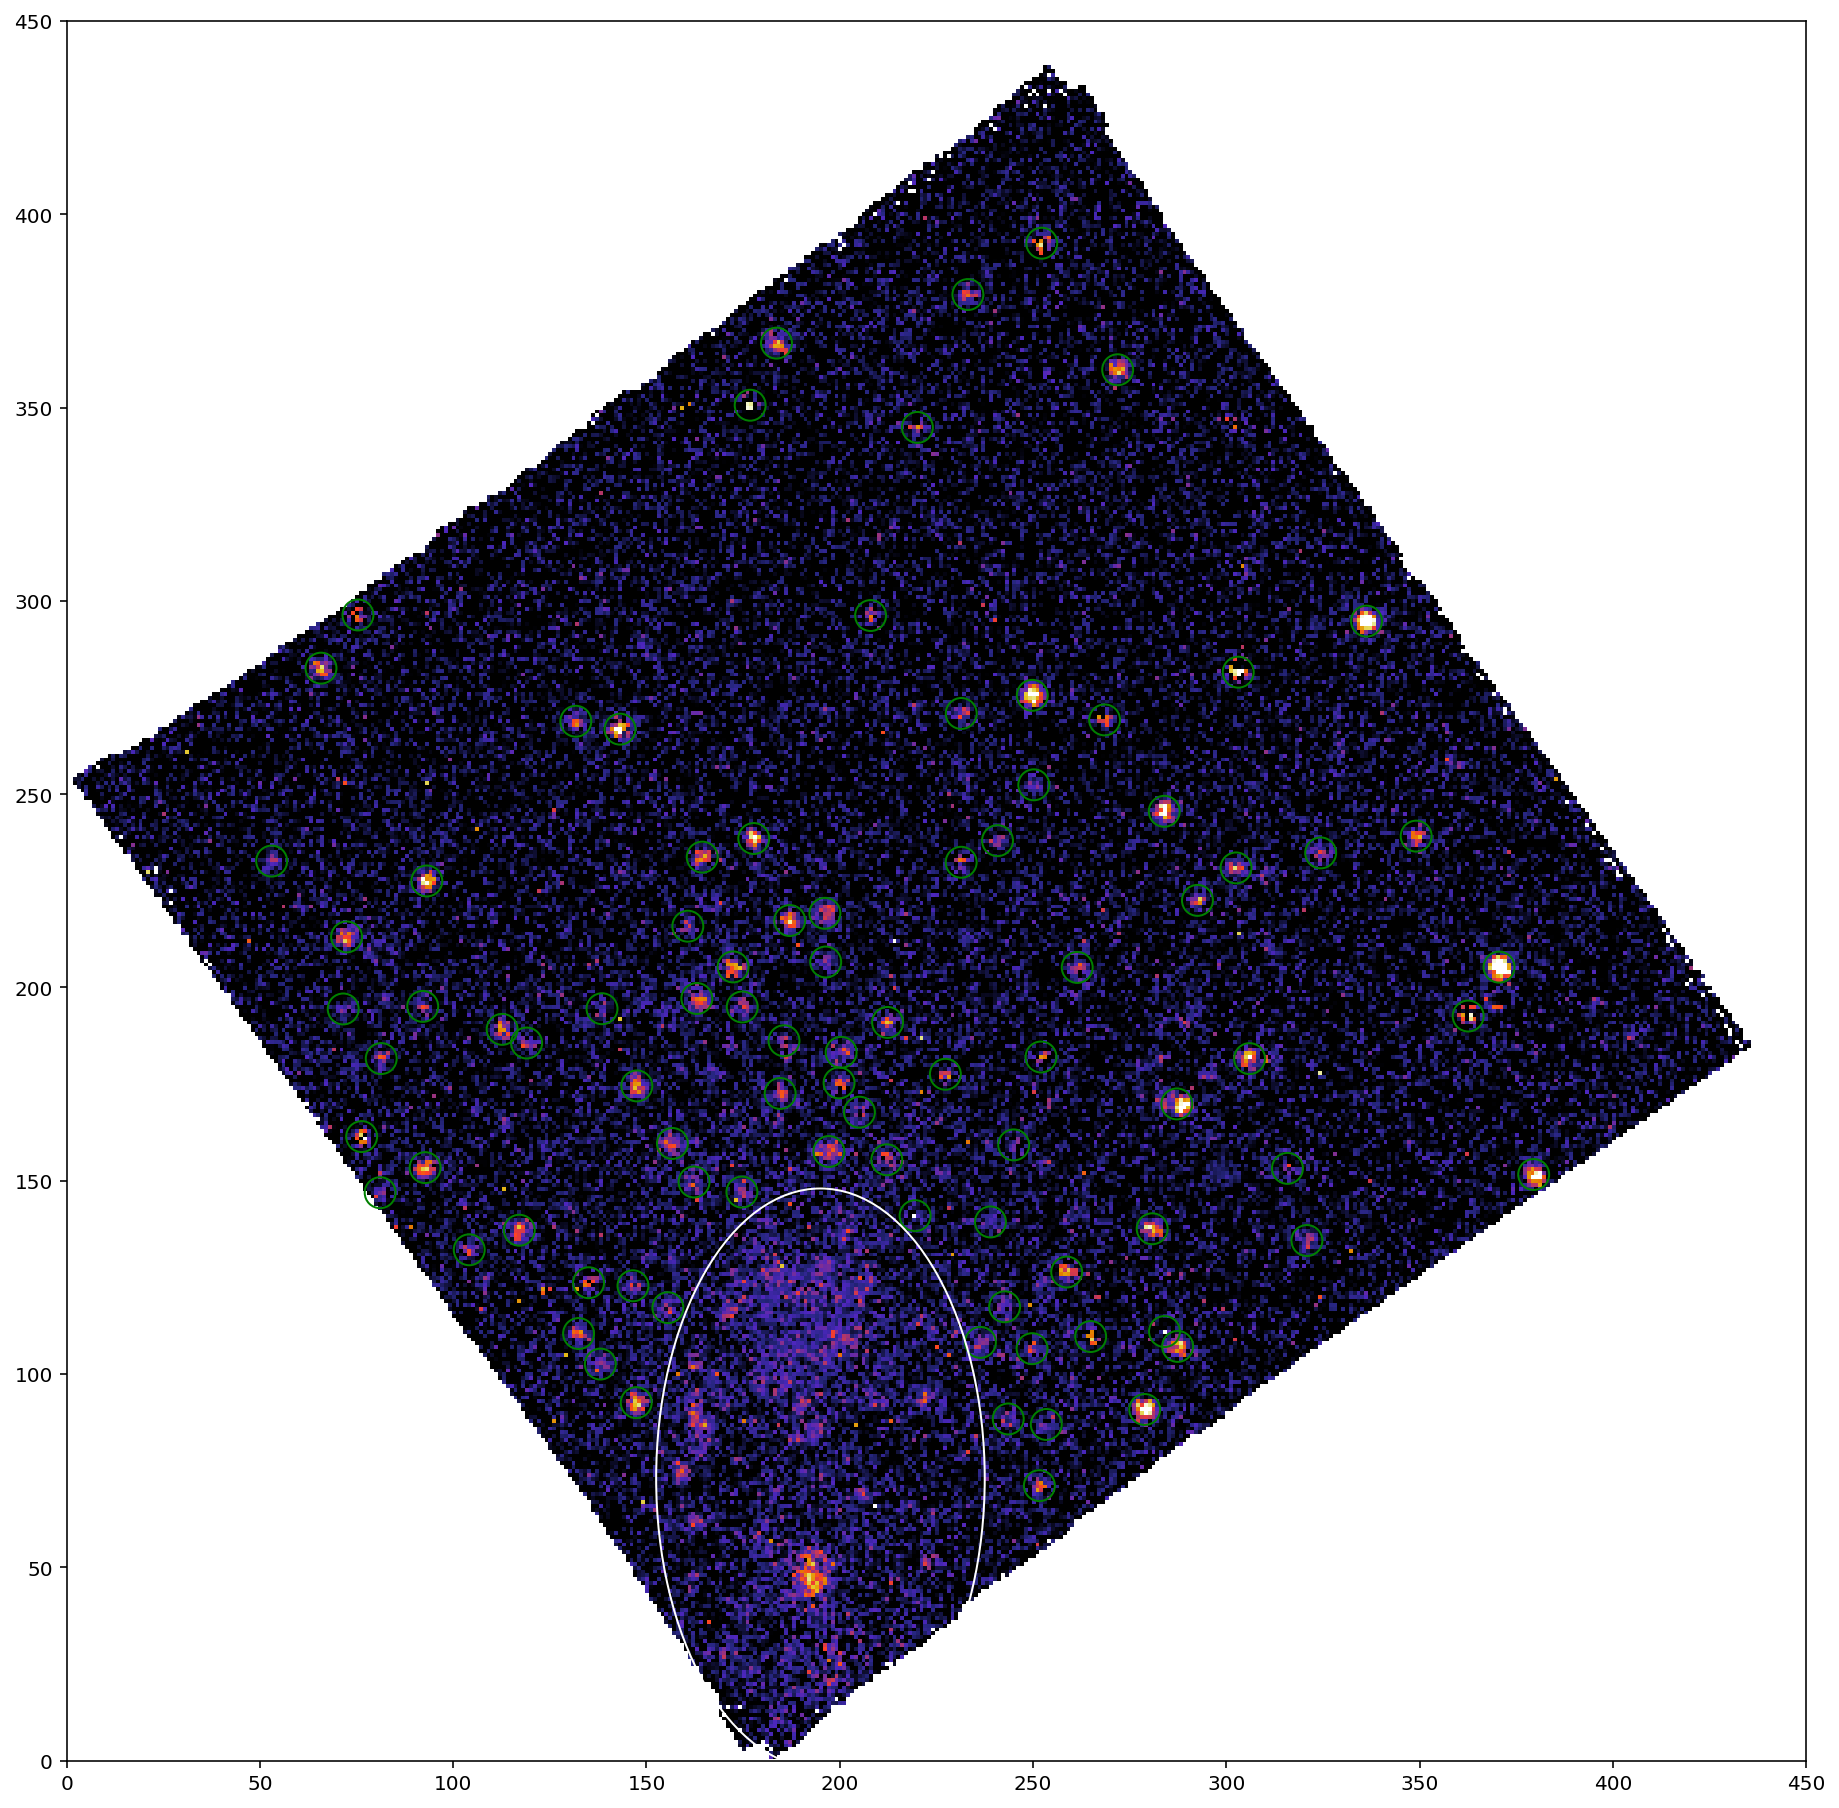

In [56]:
# new FCC167 - [237,200,150,70,0.12]

A_rN_plot_shape[A_rN_plot_shape == A_rN_plot_shape[0,0]] = 0.0
plt.figure(figsize=(20,20))

Y, X = np.mgrid[:y_data, :x_data]
xe, ye, length, width, alpha = gal_mask

elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1    

objects = sep.extract(A_rN_plot_shape, thresh=2.0, clean=True, mask=elip_mask_gal,)# filter_type="matched", minarea=7)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8.)
#plt.imshow(Flux_1D_cube, origin="lower", cmap="CMRmap", vmax=100)
apertures.plot(color="green")

plt.xlim(0,450)
plt.ylim(0,450)

ax = plt.gca()

elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white")
ax.add_artist(elip_gal)

sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]
print(len(x_sep))

#np.save("exported_data/"+gal_name+"/PNe_x_y_list", sep_x_y_list)

In [6]:
x_y_list = np.load("exported_data/"+gal_name+"/PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

PNe_spectra = np.array([PNe_spectrum_extractor(x, y, n_pixels, hdulist[0].data, x_data, wave=wavelength) for x,y in zip(x_PNe, y_PNe)])

PNe_df = pd.DataFrame(columns=("PNe number", "Ra (J2000)", "Dec (J2000)", "V (km/s)", "m 5007", "M 5007", "[OIII] Flux", "M 5007 error","A/rN", "rad D", "redchi", "Filter"))
PNe_df["PNe number"] = np.arange(0,len(x_PNe)) # PNe numbers
PNe_df["Filter"] = "Y"

# Objective Residual Cube
obj_residual_cube = fits.open("exported_data/"+gal_name+"/resids_obj.fits")

# Data Residual Cube
data_residual_cube = fits.open("exported_data/"+gal_name+"/resids_data.fits")


def uncertainty_cube_construct(data, x_P, y_P, n_pix):
    data[data == np.inf] = 0.01
    extract_data = np.array([PNe_spectrum_extractor(x, y, n_pix, data, x_data, wave=wavelength) for x,y in zip(x_P, y_P)])
    array_to_fill = np.zeros((len(x_P), n_pix*n_pix, len(wavelength)))
    for p in np.arange(0, len(x_P)):
        list_of_std = np.abs([robust_sigma(dat) for dat in extract_data[p]])
        array_to_fill[p] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]
  
    return array_to_fill

error_cube = uncertainty_cube_construct(data_residual_cube[0].data, x_PNe, y_PNe, n_pixels)
obj_error_cube = uncertainty_cube_construct(obj_residual_cube[0].data, x_PNe, y_PNe, n_pixels)

In [7]:
with open("galaxy_info.yaml", "r") as yaml_data:
    galaxy_info = yaml.load(yaml_data, Loader=yaml.FullLoader)
    
galaxy_data = galaxy_info[gal_name]

emission_dict = galaxy_data["emissions"]

#D = galaxy_data["Distance"]
gal_vel = galaxy_data["velocity"]
z = gal_vel*1e3 / c

gal_mask = galaxy_data["gal_mask"]
star_mask = galaxy_data["star_mask"]

In [70]:
# save models for Marc
#models_hdu = fits.PrimaryHDU(model_spectra_list)
#wavelenth_models = fits.ImageHDU(wavelength)
#hdu_to_write = fits.HDUList([models_hdu, wavelenth_models])
#hdu_to_write.writeto("exported_data/"+gal_name+"/3D_models_PNe.fits", overwrite=True)


In [8]:
PNe_multi_params = Parameters()

def gen_params(wave=5007, FWHM=4.0, FWHM_err=0.1, beta=2.5, beta_err=0.3, LSF=2.81, em_dict=None, vary_LSF=False, vary_PSF=False):
    # loop through emission dictionary to add different element parameters 
    for em in em_dict:
        #Amplitude params for each emission
        PNe_multi_params.add('Amp_2D_{}'.format(em), value=emission_dict[em][0], min=0.00001, max=1e5, expr=emission_dict[em][1])
        #Wavelength params for each emission
        if emission_dict[em][2] == None:
            PNe_multi_params.add("wave_{}".format(em), value=wave, min=wave-15., max=wave+15.)
        else:
            PNe_multi_params.add("wave_{}".format(em), expr=emission_dict[em][2].format(z))
    
    PNe_multi_params.add("x_0", value=((n_pixels//2.) +1), min=((n_pixels//2.) +1)-3, max=((n_pixels//2.) +1)+3)
    PNe_multi_params.add("y_0", value=((n_pixels//2.) +1), min=((n_pixels//2.) +1)-3, max=((n_pixels//2.) +1)+3)
    PNe_multi_params.add("LSF", value=LSF, vary=vary_LSF, min=LSF-1, max=LSF+1)
    PNe_multi_params.add("M_FWHM", value=FWHM, min=FWHM - FWHM_err, max=FWHM + FWHM_err, vary=vary_PSF)
    PNe_multi_params.add("beta", value=beta, min=beta - beta_err, max=beta + beta_err, vary=vary_PSF)   
    PNe_multi_params.add("Gauss_bkg",  value=0.1, vary=True)#1, min=-200, max=500)
    PNe_multi_params.add("Gauss_grad", value=0.0001, vary=True)#1, min=-2, max=2)
    
# storage setup
total_Flux = np.zeros((len(x_PNe),len(emission_dict)))
A_2D_list = np.zeros((len(x_PNe),len(emission_dict)))
F_xy_list = np.zeros((len(x_PNe), len(emission_dict), len(PNe_spectra[0])))
moff_A = np.zeros((len(x_PNe),len(emission_dict)))
model_spectra_list = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
mean_wave_list = np.zeros((len(x_PNe),len(emission_dict)))
residuals_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
chi_2_r = np.zeros((len(x_PNe)))

# error lists
moff_A_err = np.zeros((len(x_PNe), len(emission_dict)))
x_0_err = np.zeros((len(x_PNe), len(emission_dict)))
y_0_err = np.zeros((len(x_PNe), len(emission_dict)))
mean_wave_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_bkg_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_grad_err = np.zeros((len(x_PNe), len(emission_dict)))

list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))

def run_minimiser(parameters):
    for PNe_num in np.arange(0, len(x_PNe)):
        progbar(int(PNe_num)+1, len(x_PNe), 40)
        useful_stuff = []        
        PNe_minimizer     = lmfit.Minimizer(PNe_residuals_3D, PNe_multi_params, fcn_args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, emission_dict, useful_stuff), nan_policy="propagate")
        multi_fit_results = PNe_minimizer.minimize()
        total_Flux[PNe_num] = np.sum(useful_stuff[1][1],1) * 1e-20
        list_of_fit_residuals[PNe_num] = useful_stuff[0]
        A_2D_list[PNe_num]  = useful_stuff[1][0]
        F_xy_list[PNe_num]  = useful_stuff[1][1]
        model_spectra_list[PNe_num] = useful_stuff[1][3]
        moff_A[PNe_num]  = [multi_fit_results.params["Amp_2D_{}".format(em)] for em in emission_dict]
        mean_wave_list[PNe_num]     = [multi_fit_results.params["wave_{}".format(em)] for em in emission_dict]   
        chi_2_r[PNe_num]    = multi_fit_results.redchi
        list_of_x[PNe_num]  = multi_fit_results.params["x_0"]
        list_of_y[PNe_num]  = multi_fit_results.params["y_0"]
        Gauss_bkg[PNe_num]  = multi_fit_results.params["Gauss_bkg"]
        Gauss_grad[PNe_num] = multi_fit_results.params["Gauss_grad"]
        #save errors
        moff_A_err[PNe_num]     = [multi_fit_results.params["Amp_2D_{}".format(em)].stderr for em in emission_dict]
        mean_wave_err[PNe_num]  = [multi_fit_results.params["wave_{}".format(em)].stderr for em in emission_dict]
        x_0_err[PNe_num]        = multi_fit_results.params["x_0"].stderr
        y_0_err[PNe_num]        = multi_fit_results.params["y_0"].stderr
        Gauss_bkg_err[PNe_num]  = multi_fit_results.params["Gauss_bkg"].stderr
        Gauss_grad_err[PNe_num] = multi_fit_results.params["Gauss_grad"].stderr

    # Signal to noise and Magnitude calculations
    list_of_rN = np.array([robust_sigma(PNe_res) for PNe_res in list_of_fit_residuals])
    PNe_df["A/rN"] = A_2D_list[:,0] / list_of_rN # Using OIII amplitude
    
    # chi square analysis
    gauss_list, redchi, Chi_sqr = [], [], []
    for p in range(len(x_PNe)):
        PNe_n = np.copy(PNe_spectra[p])
        flux_1D = np.copy(F_xy_list[p][0])
        A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))
    
        def gaussian(x, amplitude, mean, FWHM, bkg, grad):
            stddev = FWHM/ 2.35482
            return ((bkg + grad*x) + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
                    (np.abs(amplitude)/2.85) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))
    
        list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], galaxy_data["LSF"], Gauss_bkg[p], Gauss_grad[p]) for A in A_n]
        for kk in range(len(PNe_n)):
            temp = np.copy(list_of_gauss[kk])
            idx  = np.where(PNe_n[kk] == 0.0)[0]
            temp[idx] = 0.0
            PNe_n[kk,idx] = 1.0
            list_of_gauss[kk] = np.copy(temp)
        rN   = robust_sigma(PNe_n - list_of_gauss)
        res  = PNe_n - list_of_gauss
        Chi2 = np.sum((res**2)/(rN**2))
        s    = np.shape(PNe_n)
        redchi.append(Chi2/(len(wavelength)*n_pixels**2 - PNe_minimizer.nfree))
        gauss_list.append(list_of_gauss)
        Chi_sqr.append(Chi2)
    
    PNe_df['Chi2']   = Chi_sqr
    PNe_df["redchi"] = redchi
    
    # velocity
    de_z_means = np.array(mean_wave_list[:,0] / (1 + z)) # de redshift OIII wavelength position
    
    PNe_df["V (km/s)"] = (c * (de_z_means - 5006.77) / 5006.77) / 1000.    
        
    PNe_df["[OIII] Flux"] = total_Flux[:,0] #store total OIII 5007 line flux
        
    if "hb" in emission_dict:
        PNe_df["[OIII]/Hb"] = PNe_df["[OIII] Flux"] / total_Flux[:,2] # store [OIII]/Hb ratio

    if "ha" in emission_dict:
        PNe_df["Ha Flux"] = total_Flux[:, 1]
    
    PNe_df["m 5007"] = -2.5 * np.log10(PNe_df["[OIII] Flux"].values) - 13.74


In [9]:
print("Running fitter")
if gal_name == "FCC219":
    gen_params(wave=5006.77*(1+z)-3, FWHM=galaxy_data["FWHM"], beta=galaxy_data["beta"], LSF=galaxy_data["LSF"], em_dict=emission_dict) #5007*(1+z)-3
else:
    gen_params(wave=5006.77*(1+z), FWHM=galaxy_data["FWHM"], beta=galaxy_data["beta"], LSF=galaxy_data["LSF"], em_dict=emission_dict)
    
run_minimiser(PNe_multi_params)

Running fitter
 ######################################## [100.00%] 94/94

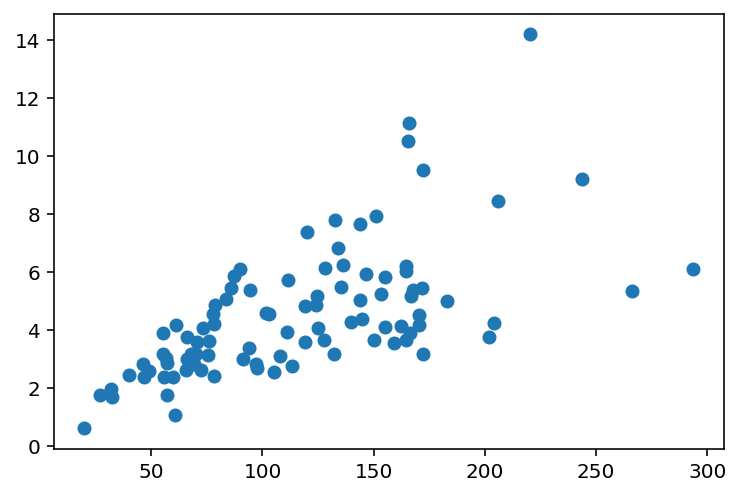

In [51]:
plt.scatter(moff_A[:,0], PNe_df["A/rN"])

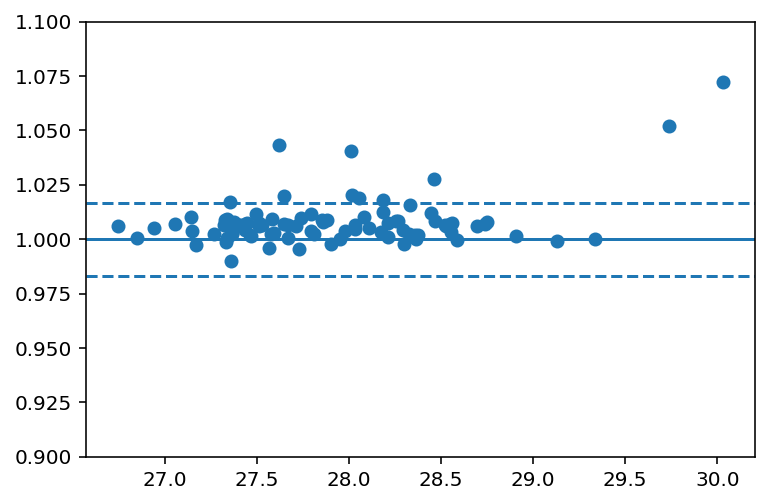

In [52]:
plt.scatter(PNe_df["m 5007"], PNe_df["redchi"])
plt.ylim(0.9,1.1)
plt.axhline(1)
plt.axhline(1+robust_sigma(PNe_df["redchi"].values)*3, ls="--")
plt.axhline(1-robust_sigma(PNe_df["redchi"].values)*3, ls="--")

## The Great Filter

70
69


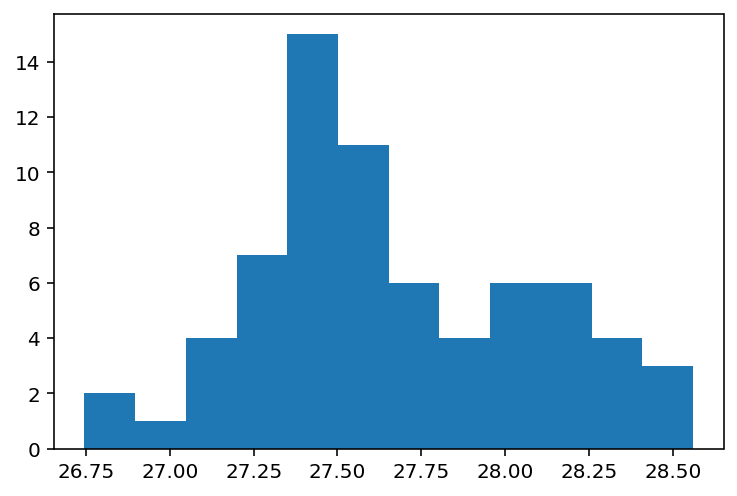

In [10]:
PNe_df["Filter"] = "Y"
PNe_df.loc[PNe_df["A/rN"]<3., "Filter"] = "N"
print(len(PNe_df["Filter"].loc[PNe_df["Filter"]=="Y"]))
# reduced Chi sqr cut
#redchi_med = np.median(PNe_df["Chi2"].values)
redchi_mid = 1
redchi_std = robust_sigma(PNe_df["redchi"].values)
lower_redchi = redchi_mid - 3*redchi_std
upper_redchi = redchi_mid + 3*redchi_std
PNe_df.loc[(PNe_df["redchi"]>=upper_redchi) & (PNe_df["redchi"]<=lower_redchi), "Filter"] = "N"


## FCC167
if gal_name == "FCC167":
#     PNe_df.loc[PNe_df["PNe number"]==30, "Filter"] = "N" # Over luminous [OIII] source
#     PNe_df.loc[PNe_df["PNe number"]==15, "Filter"] = "N" # SNR maybe, extended source with dual peaked [OIII] 5007
    #PNe_df.loc[PNe_df["PNe number"]==53, "Filter"] = "N" # 
    PNe_df.loc[PNe_df["PNe number"]==31, "Filter"] = "N"
    PNe_df.loc[PNe_df["PNe number"]==15, "Filter"] = "N"
    PNe_df.loc[PNe_df["PNe number"]==8, "Filter"] = "N"
## FCC219
elif gal_name == "FCC219":
    PNe_df.loc[PNe_df["PNe number"]==11, "Filter"] = "N"
elif gal_name == "FCC193":
    PNe_df.loc[PNe_df["PNe number"]==137, "Filter"] = "N" 
    PNe_df.loc[PNe_df["PNe number"]==59, "Filter"] = "N"
    PNe_df.loc[PNe_df["PNe number"]==136, "Filter"] = "N"
    PNe_df.loc[PNe_df["PNe number"]==122, "Filter"] = "N"
#elif gal_name == "FCC147":
    #PNe_df.loc[PNe_df["PNe number"]==41, "Filter"] = "N"
elif gal_name == "FCC249":
    PNe_df.loc[PNe_df["PNe number"]==2, "Filter"] = "N"
elif gal_name == "FCC276":
    PNe_df.loc[PNe_df["PNe number"]==23, "Filter"] = "N"
elif gal_name == "FCC184":
    PNe_df.loc[PNe_df["PNe number"]==15, "Filter"] = "N"
    PNe_df.loc[PNe_df["PNe number"]==35, "Filter"] = "N"



    

print(len(PNe_df["Filter"].loc[PNe_df["Filter"]=="Y"]))
plt.hist(PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"], bins=12);
plt.show()

# Error analysis

In [11]:
def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
        F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
        return np.sum(F_OIII_xy_dist*1e-20)
    
def error_sim(n_sim, n_PNe):
    mean_flux = np.ones(n_PNe)
    flux_err  = np.ones(n_PNe)
    mean_m5007 = np.ones(n_PNe)
    m5007_err = np.ones(n_PNe)
    for n in np.arange(0,n_PNe):
        Moff_A_dist = np.random.normal(moff_A[n][0], moff_A_err[n][0],n_sim)
        FWHM_dist = np.random.normal(galaxy_data["FWHM"], galaxy_data["FWHM_err"], n_sim)
        beta_dist = np.random.normal(galaxy_data["beta"], galaxy_data["beta_err"], n_sim)
        x_0_dist = np.random.normal(list_of_x[n], x_0_err[n][0], n_sim)
        y_0_dist = np.random.normal(list_of_y[n], y_0_err[n][0], n_sim)
        
        flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]

        mean_flux[n], flux_err[n] = norm.fit(flux_array)
        
        mean_m5007[n], m5007_err[n] = norm.fit(-2.5*np.log10(flux_array)-13.72)

    return mean_flux, flux_err, mean_m5007, m5007_err

mean_flux, PNe_df["Flux error"], mean_m5007, PNe_df["m 5007 error"] = error_sim(5000, len(x_PNe))

## Show F_err in percentage terms
PNe_df["F[OIII] err percent"] = (PNe_df["Flux error"] / PNe_df["[OIII] Flux"])*100

/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log10


## Distance estimate with error

In [62]:
PNe_df.loc[PNe_df["Filter"]=="Y"].nsmallest(3, "m 5007")

PNe number Ra (J2000) Dec (J2000)    V (km/s)     m 5007    M 5007  \
4            4        NaN         NaN   -5.413956  26.730396 -4.510000   
29          29        NaN         NaN  -91.370597  26.831793 -4.408603   
3            3        NaN         NaN -107.056443  26.926479 -4.313917   

     [OIII] Flux M 5007 error      A/rN rad D    redchi Filter          Chi2  \
4   6.483980e-17          NaN  6.100668   NaN  1.008856      Y  15281.135694   
29  5.905857e-17          NaN  5.355304   NaN  1.005421      Y  15229.107856   
3   5.412631e-17          NaN  9.227155   NaN  1.007487      Y  15260.409096   

    [OIII]/Hb    Flux error  m 5007 error  F[OIII] err percent  
4    0.365916  2.570664e-18      0.042990             3.964639  
29   0.013108  2.512872e-18      0.046141             4.254881  
3    0.010607  1.804587e-18      0.036209             3.334030

In [12]:
p_n = int(PNe_df.loc[PNe_df["Filter"]=="Y"].nsmallest(1, "m 5007").index.values)
flux = PNe_df["[OIII] Flux"].iloc[p_n]
flux_err = PNe_df["Flux error"].iloc[p_n]
m = PNe_df["m 5007"].iloc[p_n]
m_err = PNe_df["m 5007 error"].iloc[p_n]
print("PNe: ", p_n)

M_star = -4.52
M_star_err = 0.08
D_diff_eq = 0.2 * np.log(10) * (10**(0.2*(m + 4.52 - 25)))

Dist_est = 10.**(((m + 4.52) -25.) / 5.)
Dist_err = np.sqrt((D_diff_eq**2 * m_err**2) + ((-D_diff_eq)**2 * M_star_err**2))

print("Distance Estimate from PNLF: ", "{:.3f}".format(Dist_est), "+/-{0:.4f}".format(Dist_err),"Mpc")


dM =  5. * np.log10(Dist_est) + 25.
dM_diff_eq = 5/(np.log(10) * Dist_est)
dM_err = np.abs(dM_diff_eq)*Dist_err


# testing
#Dist_est = 18.79
#dM = 5. * np.log10(Dist_est) + 25.
#

print("dM = {:.3f}".format(dM),"+/- {:.3f}".format(dM_err))

PNe_df["M 5007"] = PNe_df["m 5007"] - dM

PNe:  5
Distance Estimate from PNLF:  17.907 +/-0.7686 Mpc
dM = 31.265 +/- 0.093


In [ ]:
### FCC167
PNe:  127
Distance Estimate from PNLF:  18.719 +/-0.7933 Mpc
dM = 31.361 +/- 0.092

### FCC219

### FCC193


### FCC161


### FCC147


### FCC083


### FCC255


### FCC249


### FCC310


### FCC277


### FCC276


### FCC184


## Pixel array size experiment

In [ ]:
# n_pix_dist = 31
n_range = np.arange(11,22,2)
store_here = np.ones(len(n_range))
for i, n_pix_dist in enumerate(n_range):
    coordinates = [(n,m) for n in range(n_pix_dist) for m in range(n_pix_dist)]
    x_fit = np.array([item[0] for item in coordinates])
    y_fit = np.array([item[1] for item in coordinates])
    
    n_sim = 10000
    Moff_A_dist = np.random.normal(moff_A[40][0], moff_A_err[40][0],n_sim)
    FWHM_dist = np.random.normal(4.06, 0.018, n_sim)
    beta_dist = np.random.normal(3.41, 0.167, n_sim)
    x_0_dist = np.random.normal(list_of_x[40], x_0_err[40][0], n_sim)
    y_0_dist = np.random.normal(list_of_y[40], y_0_err[40][0], n_sim)
    
    def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
        F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
    
        return np.sum(F_OIII_xy_dist*1e-20)
    
    flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]
    plt.hist(flux_array)
    plt.axvline(PNe_df["[OIII] Flux"].iloc[40])
    #plt.xlim(3.6e-17, 4.2e-17)
    #print(PNe_df["[OIII] Flux"].iloc[40])
    #print(PNe_df["m 5007"].iloc[40])
    mu_f, std_f = norm.fit(flux_array)
    #print(mu, (std/mu)*100,"%")
    plt.axvline(mu_f, c="r")
    
    mu, std = norm.fit(-2.5*np.log10(flux_array)-13.72)
    #print(mu, std)
    store_here[i] = mu_f

print(np.abs((-2.5*np.log10(store_here.max()) - 13.74)  -  (-2.5*np.log10(store_here[1]) - 13.74)))

plt.figure()
plt.plot(n_range, store_here)
plt.axvline(n_pixels)
# Correction for n_pixel and flux variation from fit

## Integrated spectrum with fit

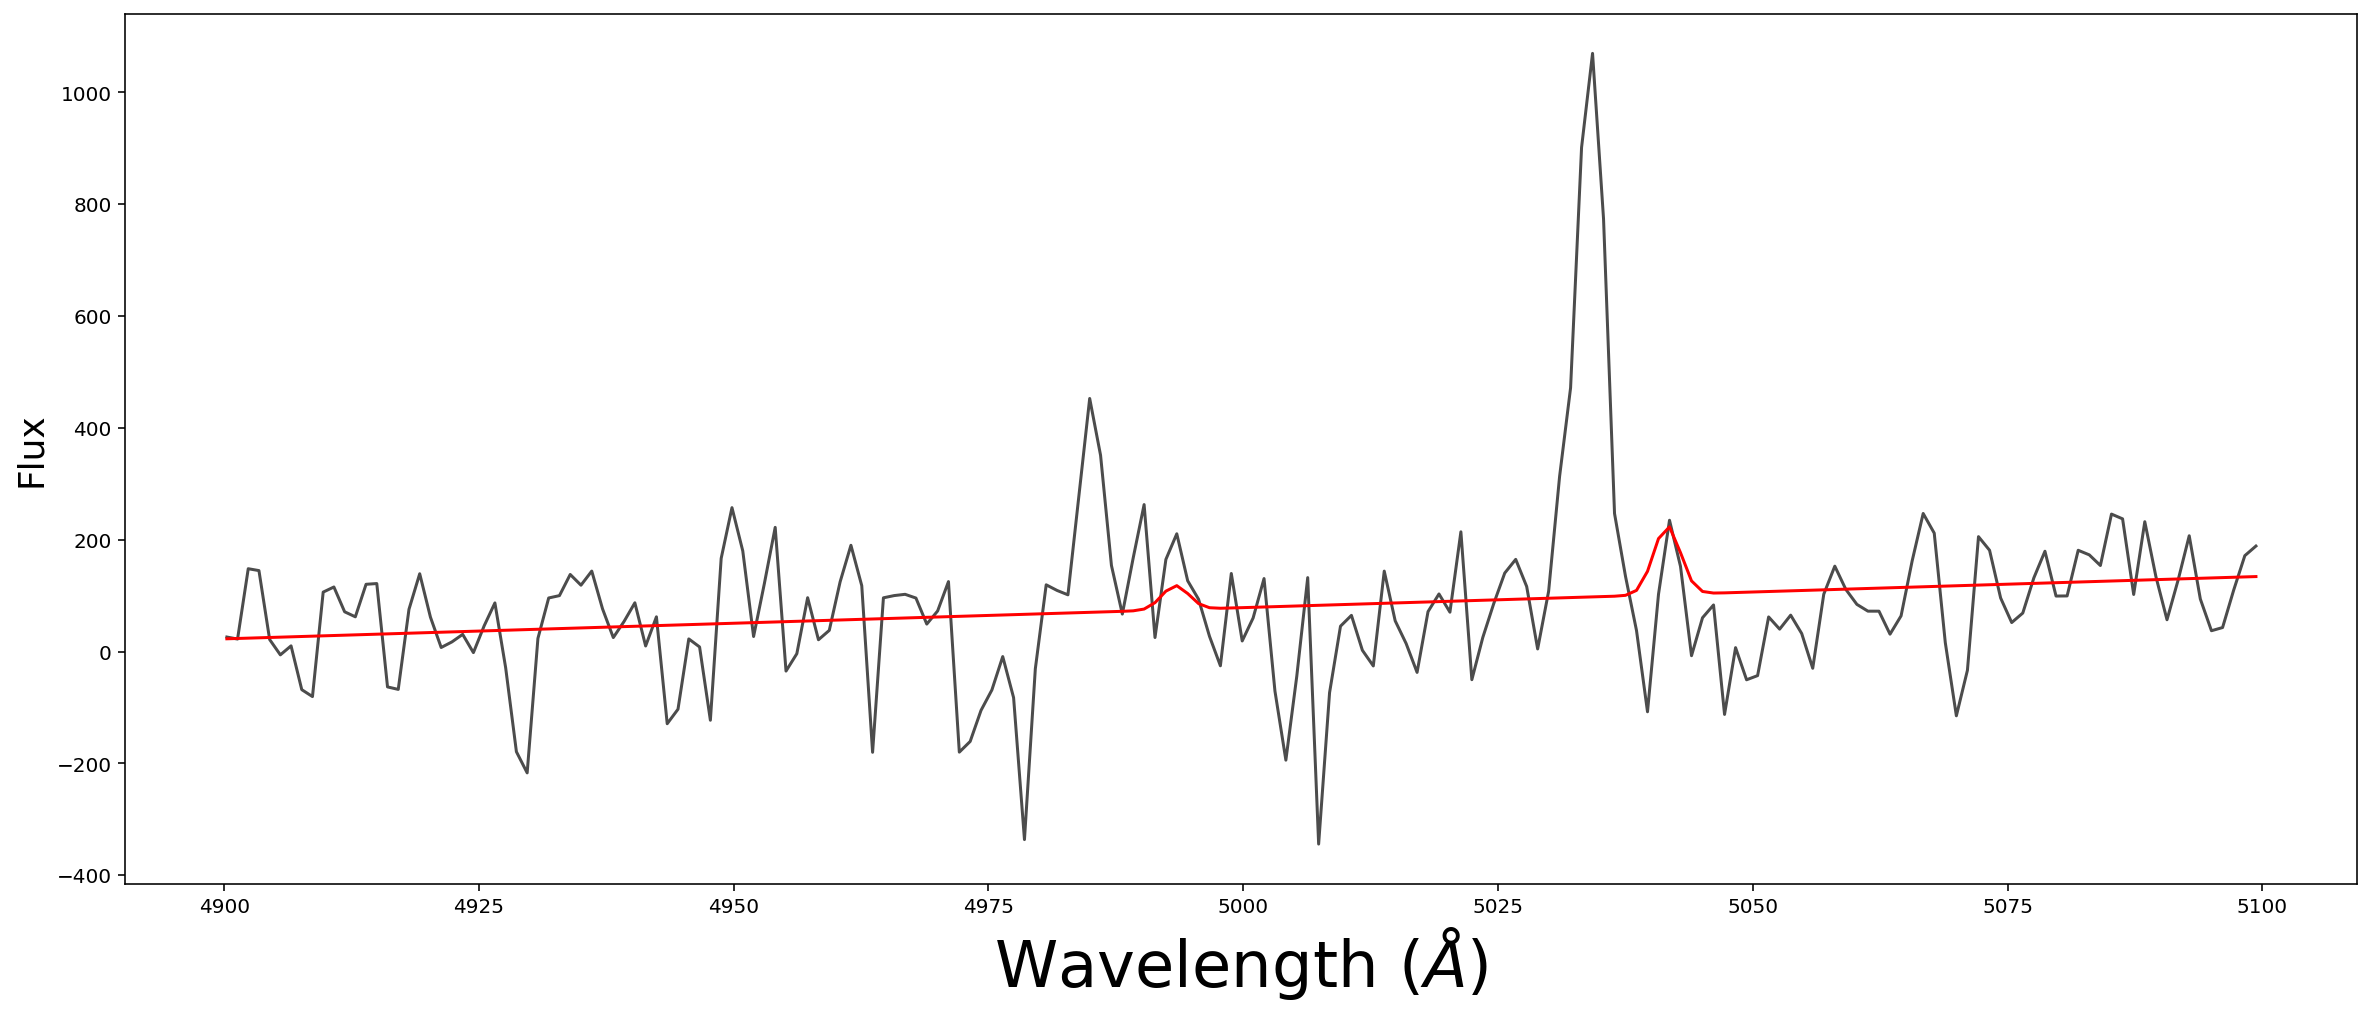

In [67]:
p = 32
plt.figure(figsize=(20,8))
plt.plot(wavelength, np.sum(PNe_spectra[p],0), alpha=0.7, c="k") # *moff_weight[:,None]

plt.plot(wavelength, np.sum(model_spectra_list[p],0), c="r")
plt.xlabel("Wavelength ($\AA$)", fontsize=32)
plt.ylabel("Flux", fontsize=18);
#plt.ylim(-1000,3500);
#plt.axvline(5042)
#plt.xlim(4900,5100)
#plt.axvline(5039)
#plt.axvline(5033)
#plt.savefig("Plots/FCC167/PNe_50_resid.png")

## Spaxel by spaxel with individual fits

Text(0.5, 0, 'Wavelength ($\\AA$)')

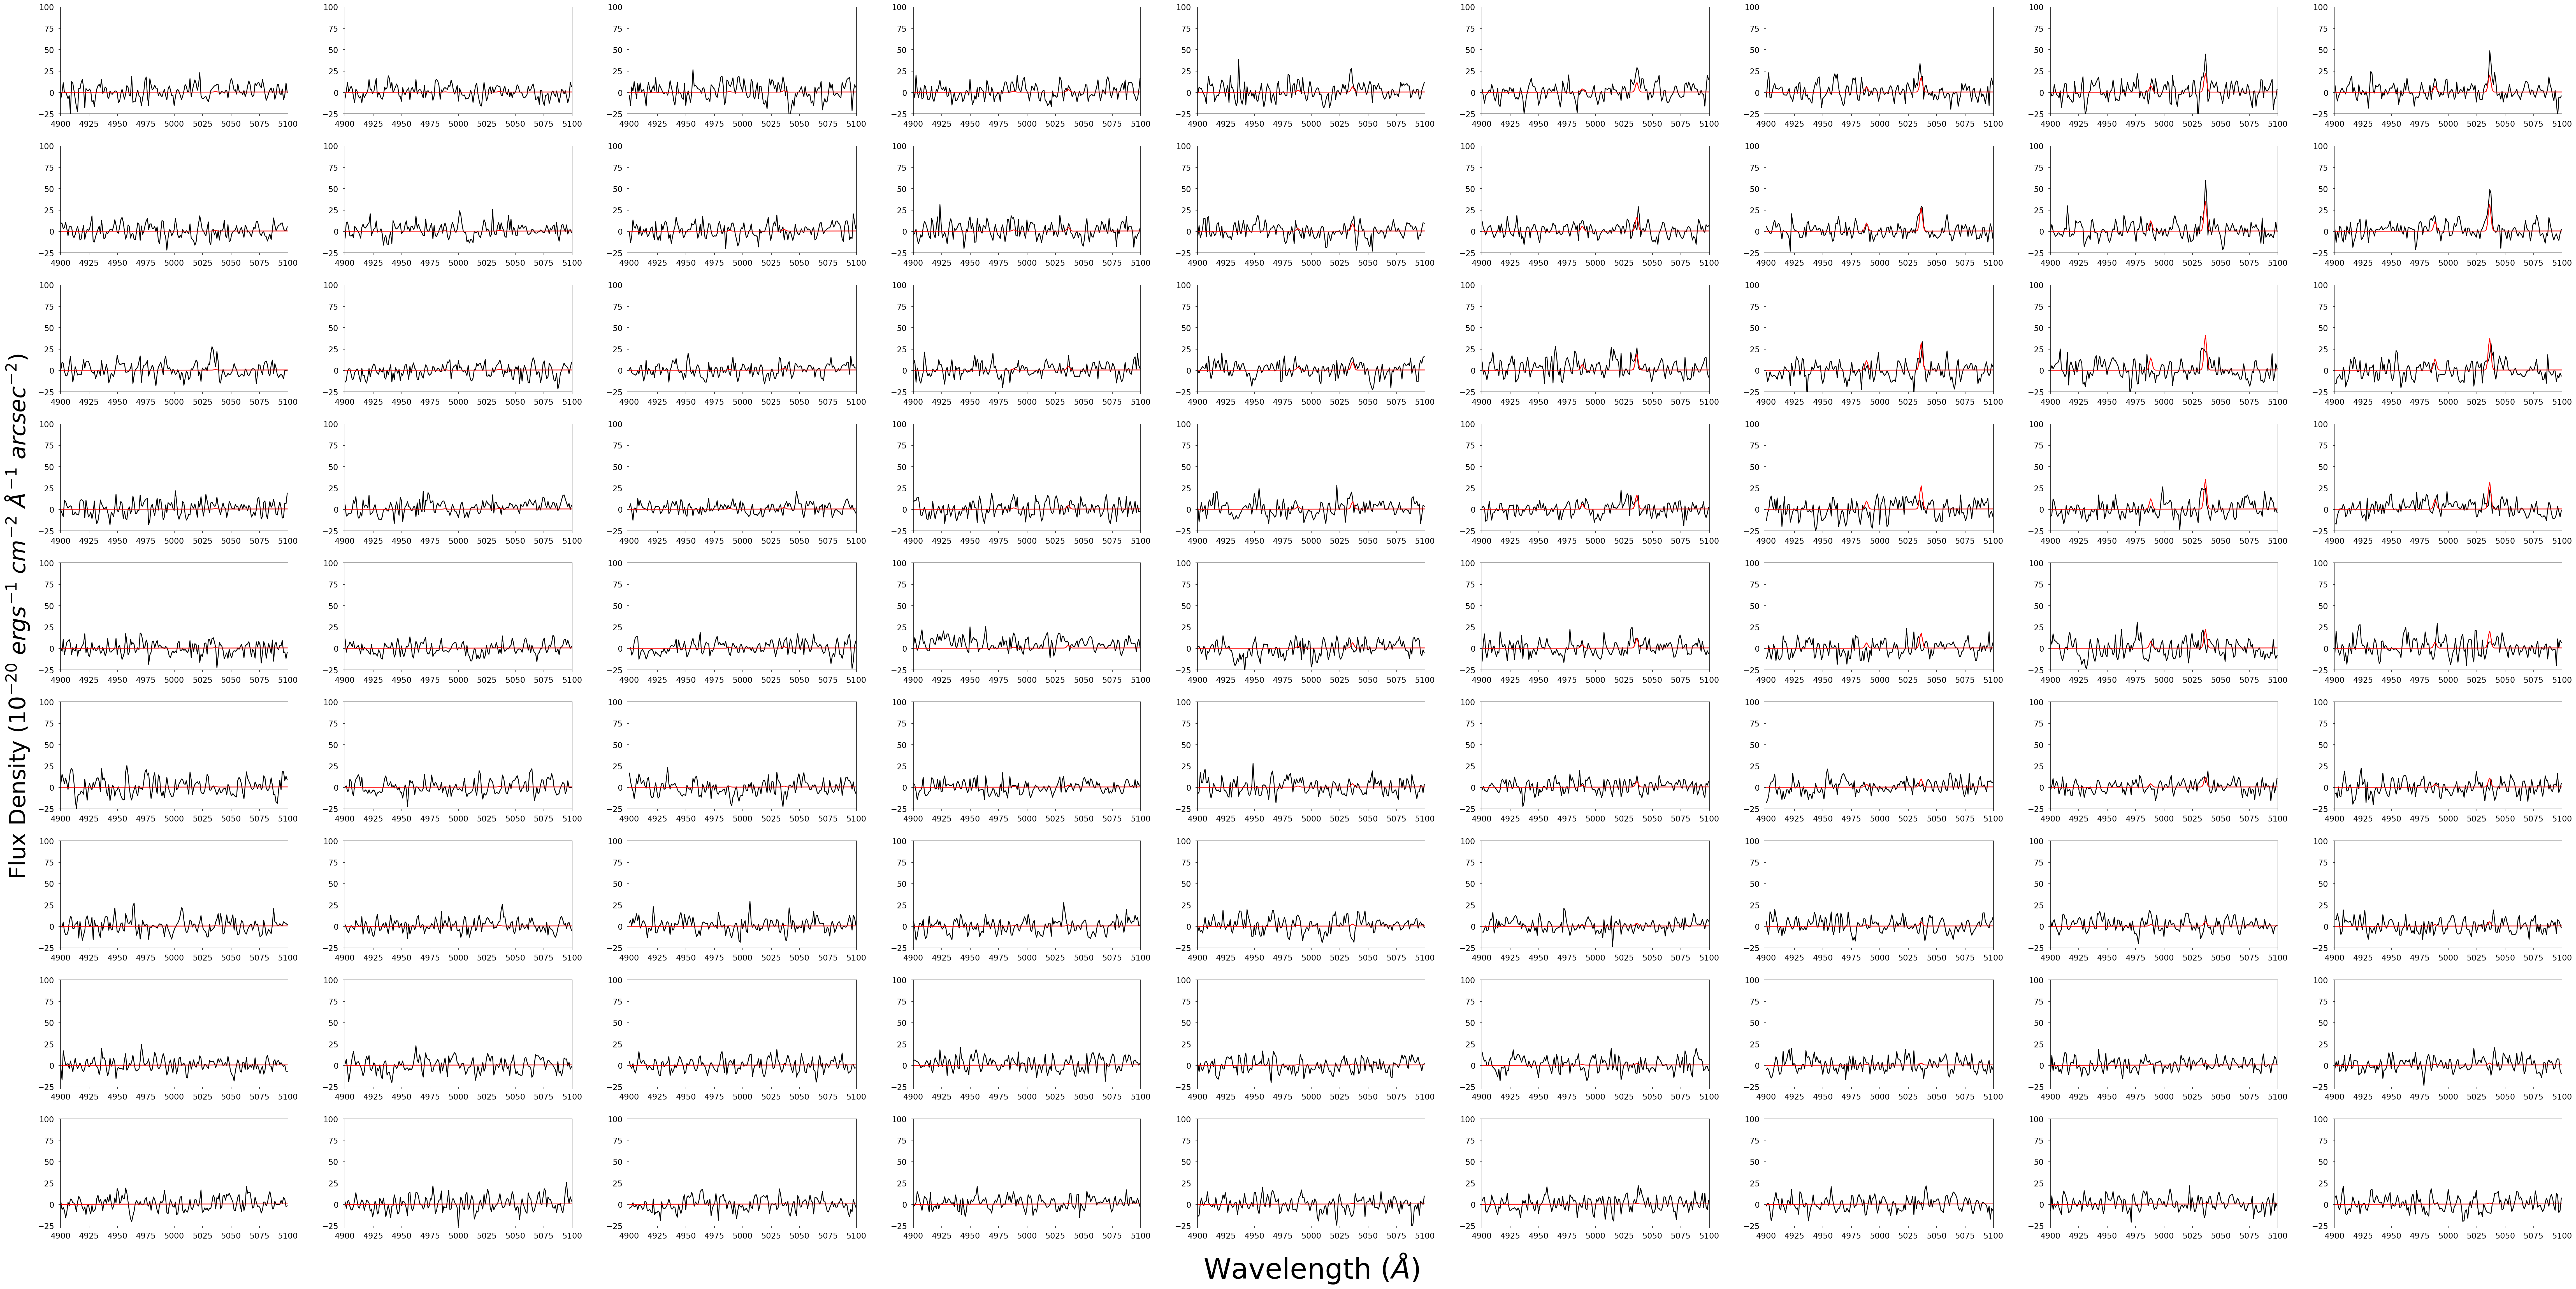

In [48]:
p = 11
PNe_n = PNe_spectra[p]
flux_1D = F_xy_list[p][0]
A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
            (np.abs(amplitude)/2.85) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))

list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], 1.19, Gauss_bkg[p], Gauss_grad[p]) for A in A_n]

fig = plt.figure(figsize=(80,40))

ax = fig.add_subplot(1,1,1)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)


for i, spec in enumerate(PNe_n):
    ax1 = fig.add_subplot(n_pixels,n_pixels,i+1)
    fig.subplots_adjust(wspace=0.25, hspace=0.3)
    ax1.plot(wavelength, spec, c="k")
    ax1.plot(wavelength, list_of_gauss[i], c="r", alpha=1.0)
    ax1.tick_params(labelsize = 14, pad=8)
    ax1.set_xlim(4900,5100)
    ax1.set_ylim(-25, 100)

    
ax.set_ylabel("Flux Density ($10^{-20}$ $erg s^{-1}$ $cm^{-2}$ $\AA^{-1}$ $arcsec^{-2}$)", fontsize=40, labelpad=30)
ax.set_xlabel("Wavelength ($\AA$)", fontsize=50, labelpad=30)

#plt.savefig("Plots/"+gal_name+"/"+gal_name+"_"+"{}".format(p)+"_spaxel_by_spaxel_fit_view.pdf", bbox_inches='tight')

## [OIII] / Ha   (+[NII])

In [18]:
y_idx = PNe_df.loc[PNe_df["Filter"]=="Y"].index.values
n_idx = PNe_df.loc[PNe_df["Filter"]=="N"].index.values

Text(0.5, 0, '$M_{5007}$')

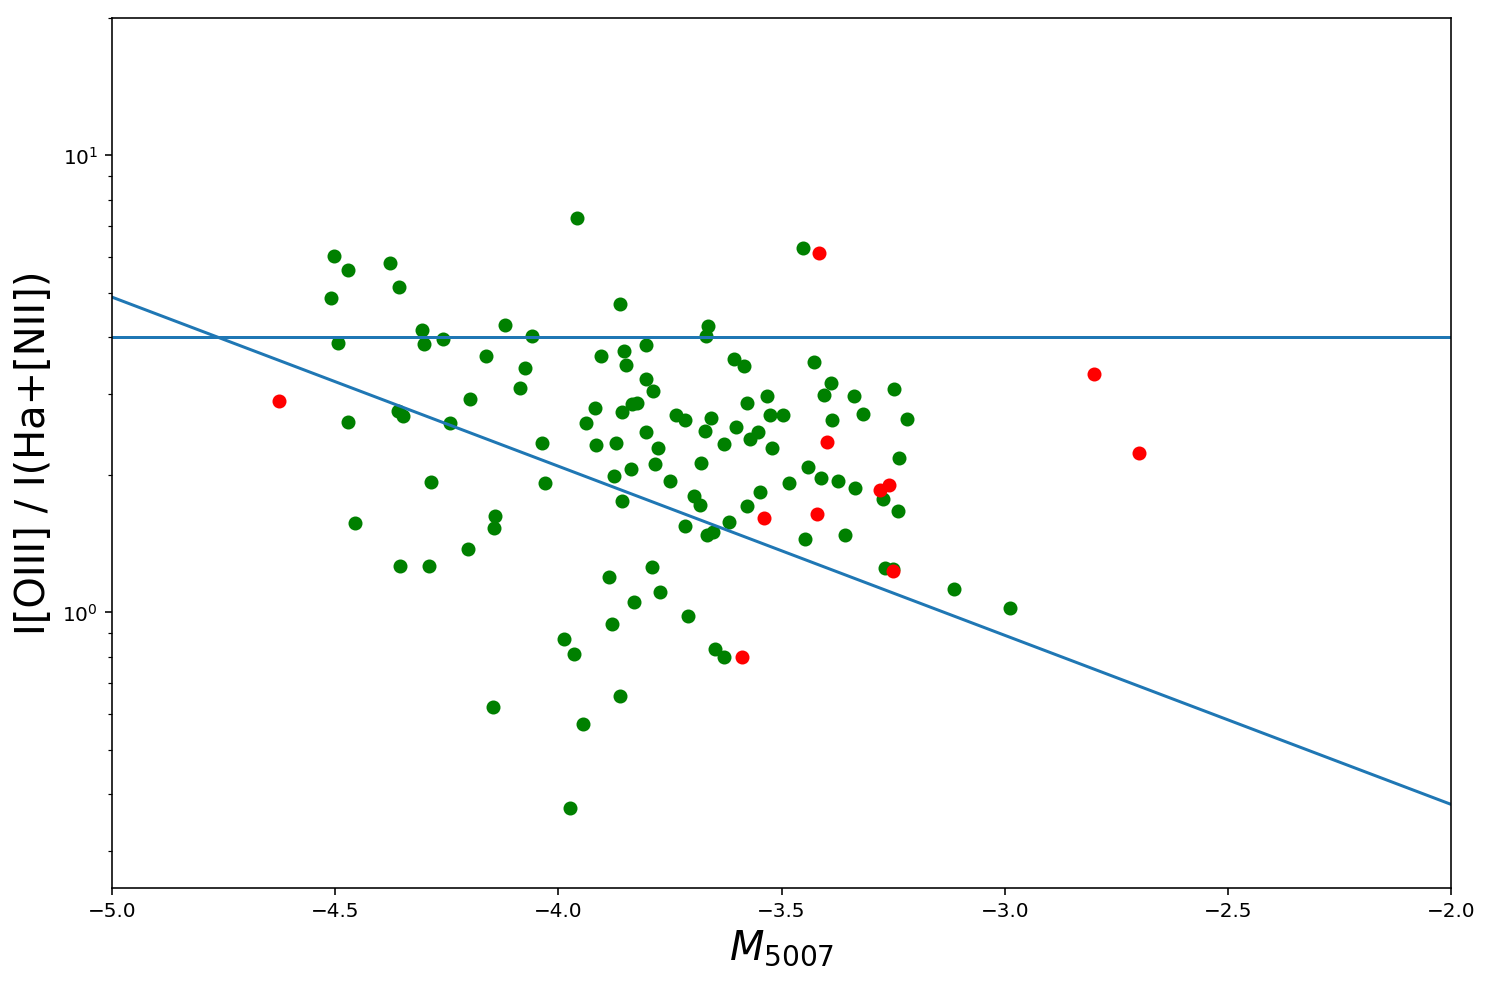

In [15]:
em_ratios = np.load("exported_data/FCC167/gandalf/emission_ratios.npy")
OIII_by_Ha, OIII_by_Ha_plus_NII, NII_by_Ha, OIII_by_SII = em_ratios

PNe_df["OIII/Ha"] = OIII_by_Ha
PNe_df["OIII/Ha+NII"] = OIII_by_Ha_plus_NII
PNe_df["NII/Ha"] = NII_by_Ha
PNe_df["OIII/SII"] = OIII_by_SII

plt.figure(figsize=(12,8))
plt.yscale("log")
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"], OIII_by_Ha_plus_NII[y_idx], c="g")
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="N"], OIII_by_Ha_plus_NII[n_idx], c="r")

plt.axhline(4)
plt.ylim(0.25,20)
plt.xlim(-5,-2)
x = np.arange(-5, -2,0.001)
plt.plot(x, 10**((-0.37 * x) - 1.16))
plt.ylabel("I[OIII] / I(Ha+[NII])", fontsize="20")
plt.xlabel("$M_{5007}$", fontsize="20")
# plt.savefig("Plots/FCC167/[OIII]Ha+NII.png")

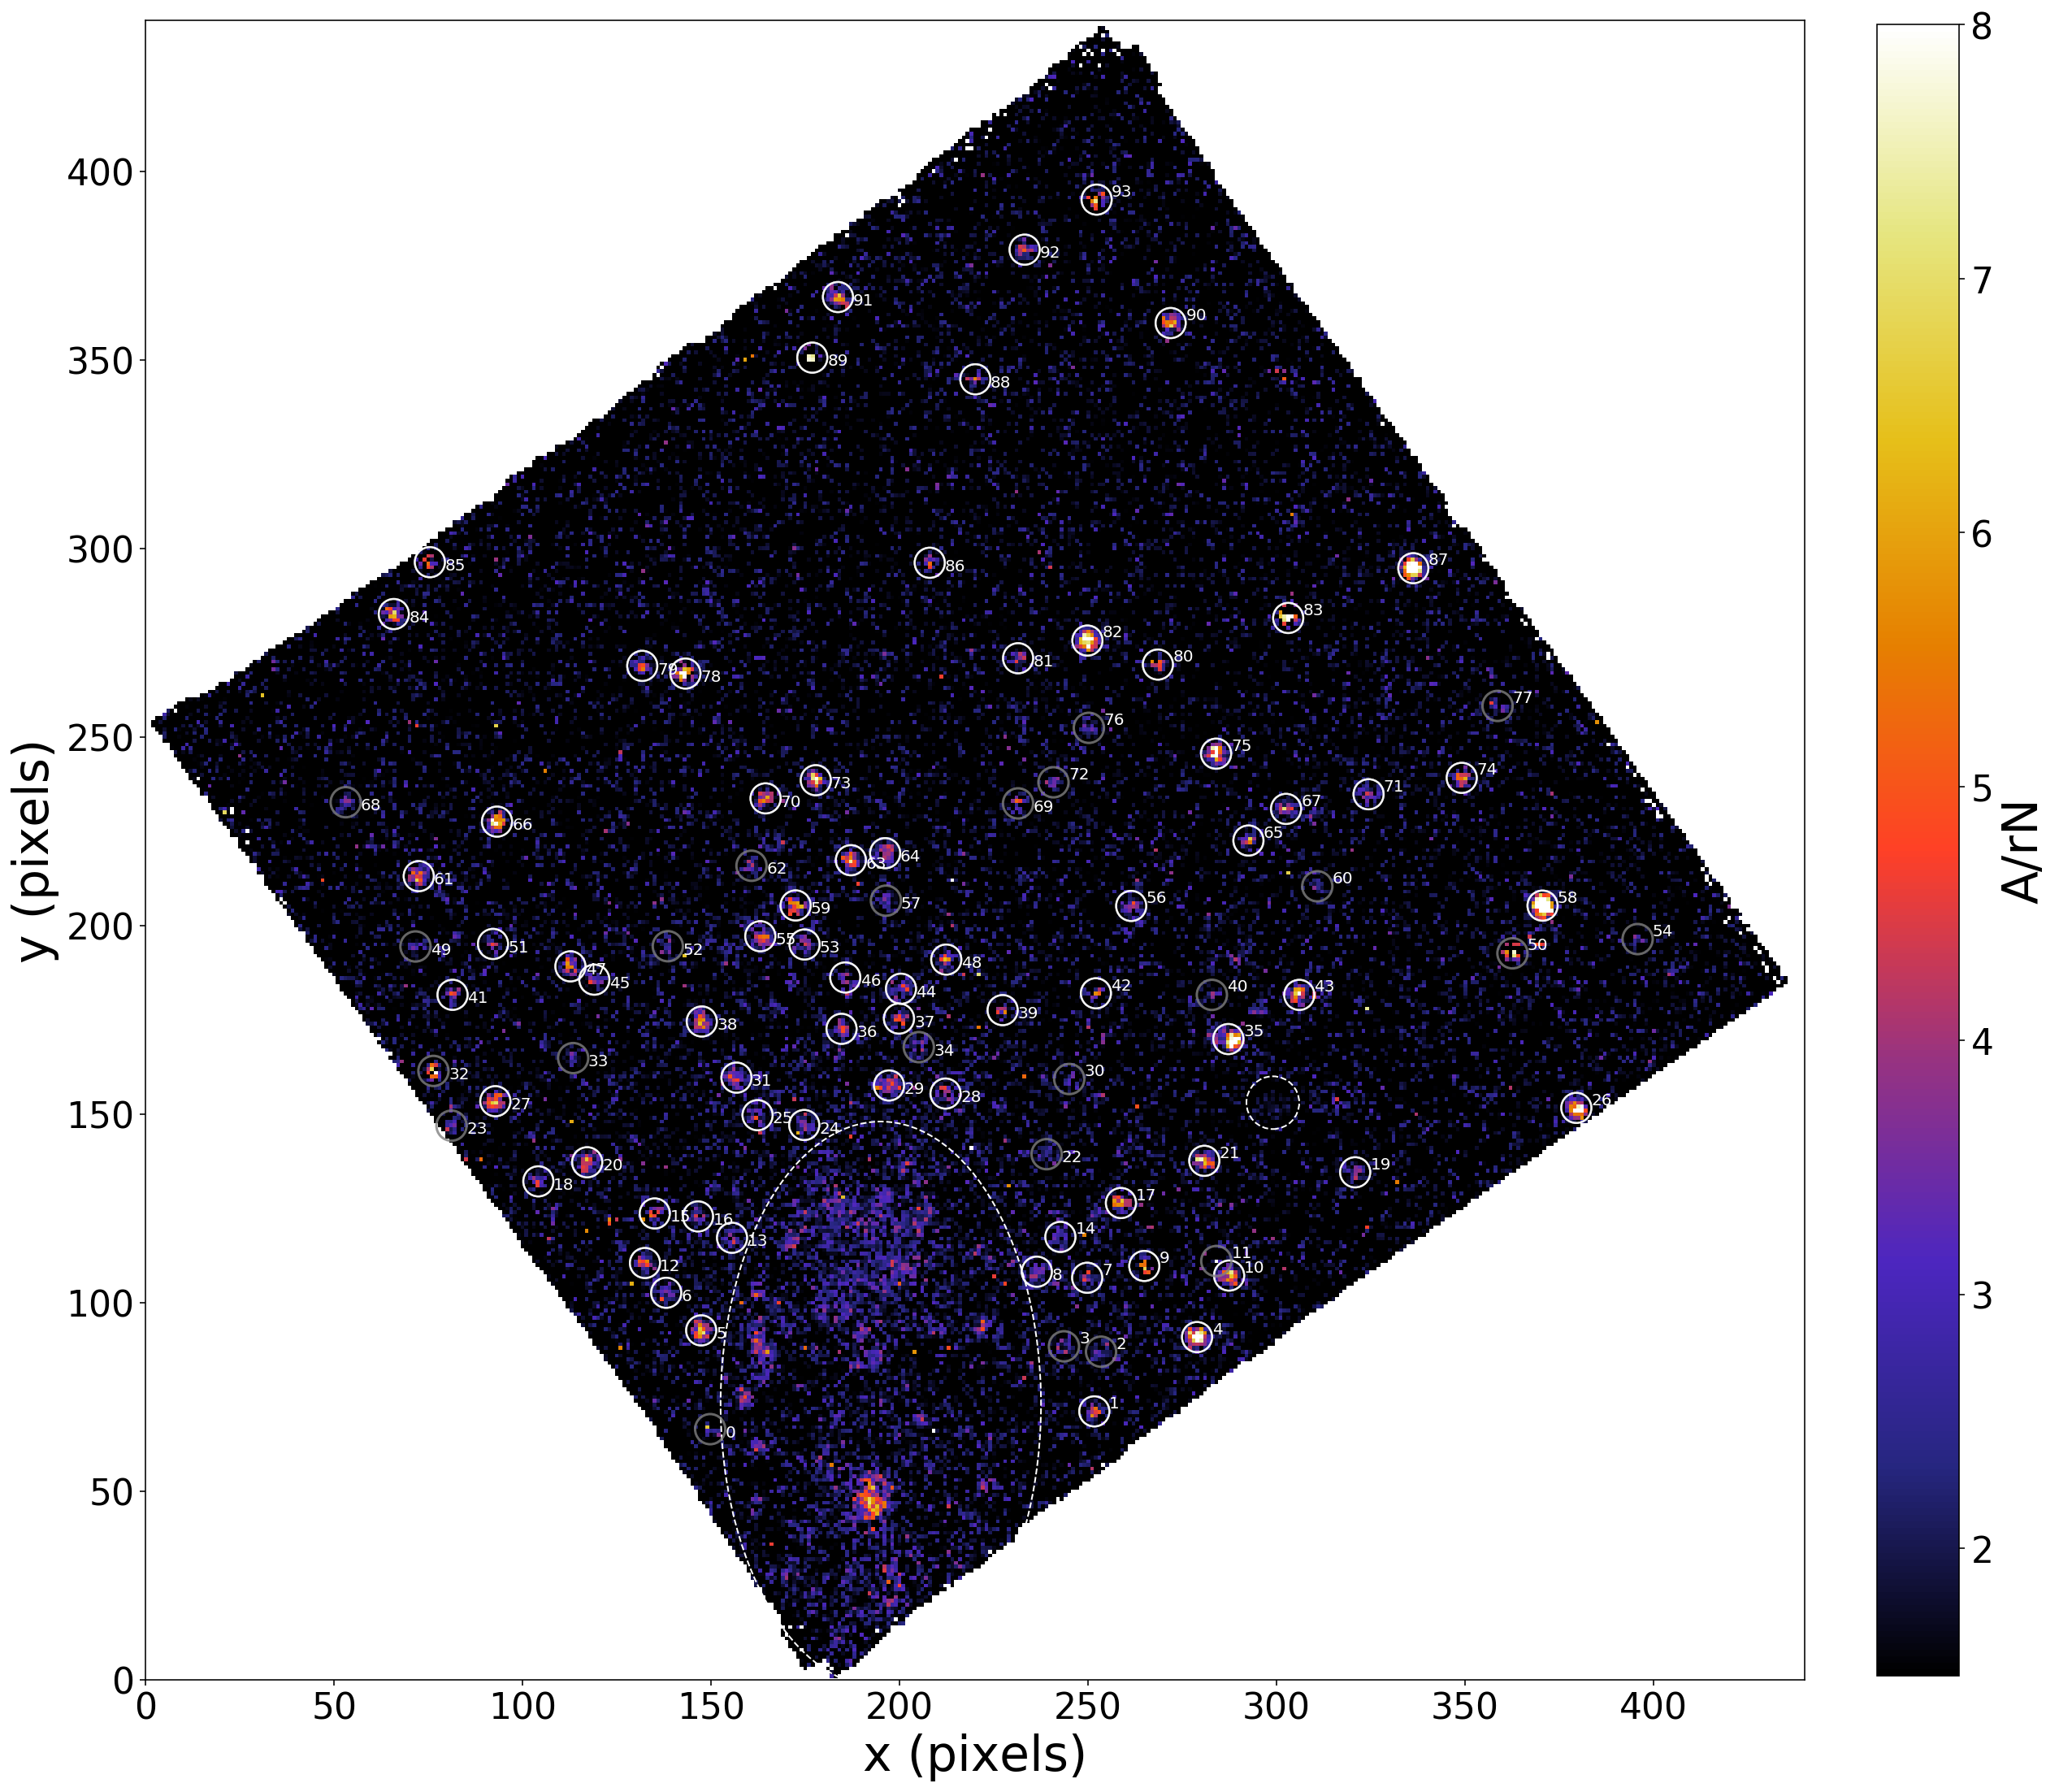

In [65]:
plt.figure(figsize=(20,20))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap",  vmin=1.5, vmax=8)
#plt.imshow(Flux_1D_cube, origin="lower", cmap="CMRmap",  vmin=10, vmax=150)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)

plt.xlabel("x (pixels)", fontsize=30)
plt.ylabel("y (pixels)", fontsize=30)

plt.tick_params(labelsize = 22)

Y, X = np.mgrid[:y_data, :x_data]
xe, ye, length, width, alpha = gal_mask

if gal_name=="FCC219":
    plt.ylim(0,440)
    plt.xlim(0,440)
elif gal_name=="FCC193":
    plt.ylim(250,)
    plt.xlim(0,350)
elif gal_name=="FCC161":
    plt.xlim(0,450)
elif gal_name=="FCC147":
    plt.xlim(230,)
    plt.ylim(0,320)
elif gal_name=="FCC083":
    plt.xlim(0,370)
    plt.ylim(0,370)
elif gal_name=="FCC310":
    plt.xlim(0,410)
    plt.ylim(100,)
elif gal_name=="FCC276":
    plt.xlim(310,)
elif gal_name=="FCC184":
    plt.xlim(0,450)
    plt.ylim(0,450)

elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white", ls="--")
star_1 = Circle((star_mask[0][0], star_mask[0][1]), radius=7, fill=False, color="white", ls="--")
ax.add_artist(star_1)
ax.add_artist(elip_gal)

for i, item in enumerate(x_y_list):
    if PNe_df.iloc[i].Filter == "Y":
        ax = plt.gca()
        circ = plt.Circle((item[0],item[1]),4, color="white",lw=1.2, fill=False, alpha=0.8)
        ax.add_artist(circ)
    elif PNe_df.iloc[i].Filter == "N":
        ax = plt.gca()
        circ = plt.Circle((item[0],item[1]),4, color="grey",lw=1.5, fill=False, alpha=0.8)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(i, (item[0]+4, item[1]-2), color="white", size=10)
    else:
        ax.annotate(i, (item[0]+4, item[1]+1), color="white", size=10)

        
# for i in contamination:
#     ax = plt.gca()
#     circ = plt.Circle((x_PNe[i],y_PNe[i]),6, color="r",lw=1.0, fill=False, alpha=0.7)
#     ax.add_artist(circ)
    
#plt.axvline(190)
#plt.axhline(110)
#plt.savefig("Plots/"+gal_name+"/"+gal_name+"_A_rN_circled.png", bbox_inches='tight')
#plt.savefig("Plots/"+gal_name+"/"+gal_name+"_A_rN_circled.pdf", bbox_inches='tight')
#plt.savefig("Plots/"+gal_name+"/"+gal_name+"_Flux_circled.pdf", bbox_inches='tight')

# Scatter points for measured PNe velocity

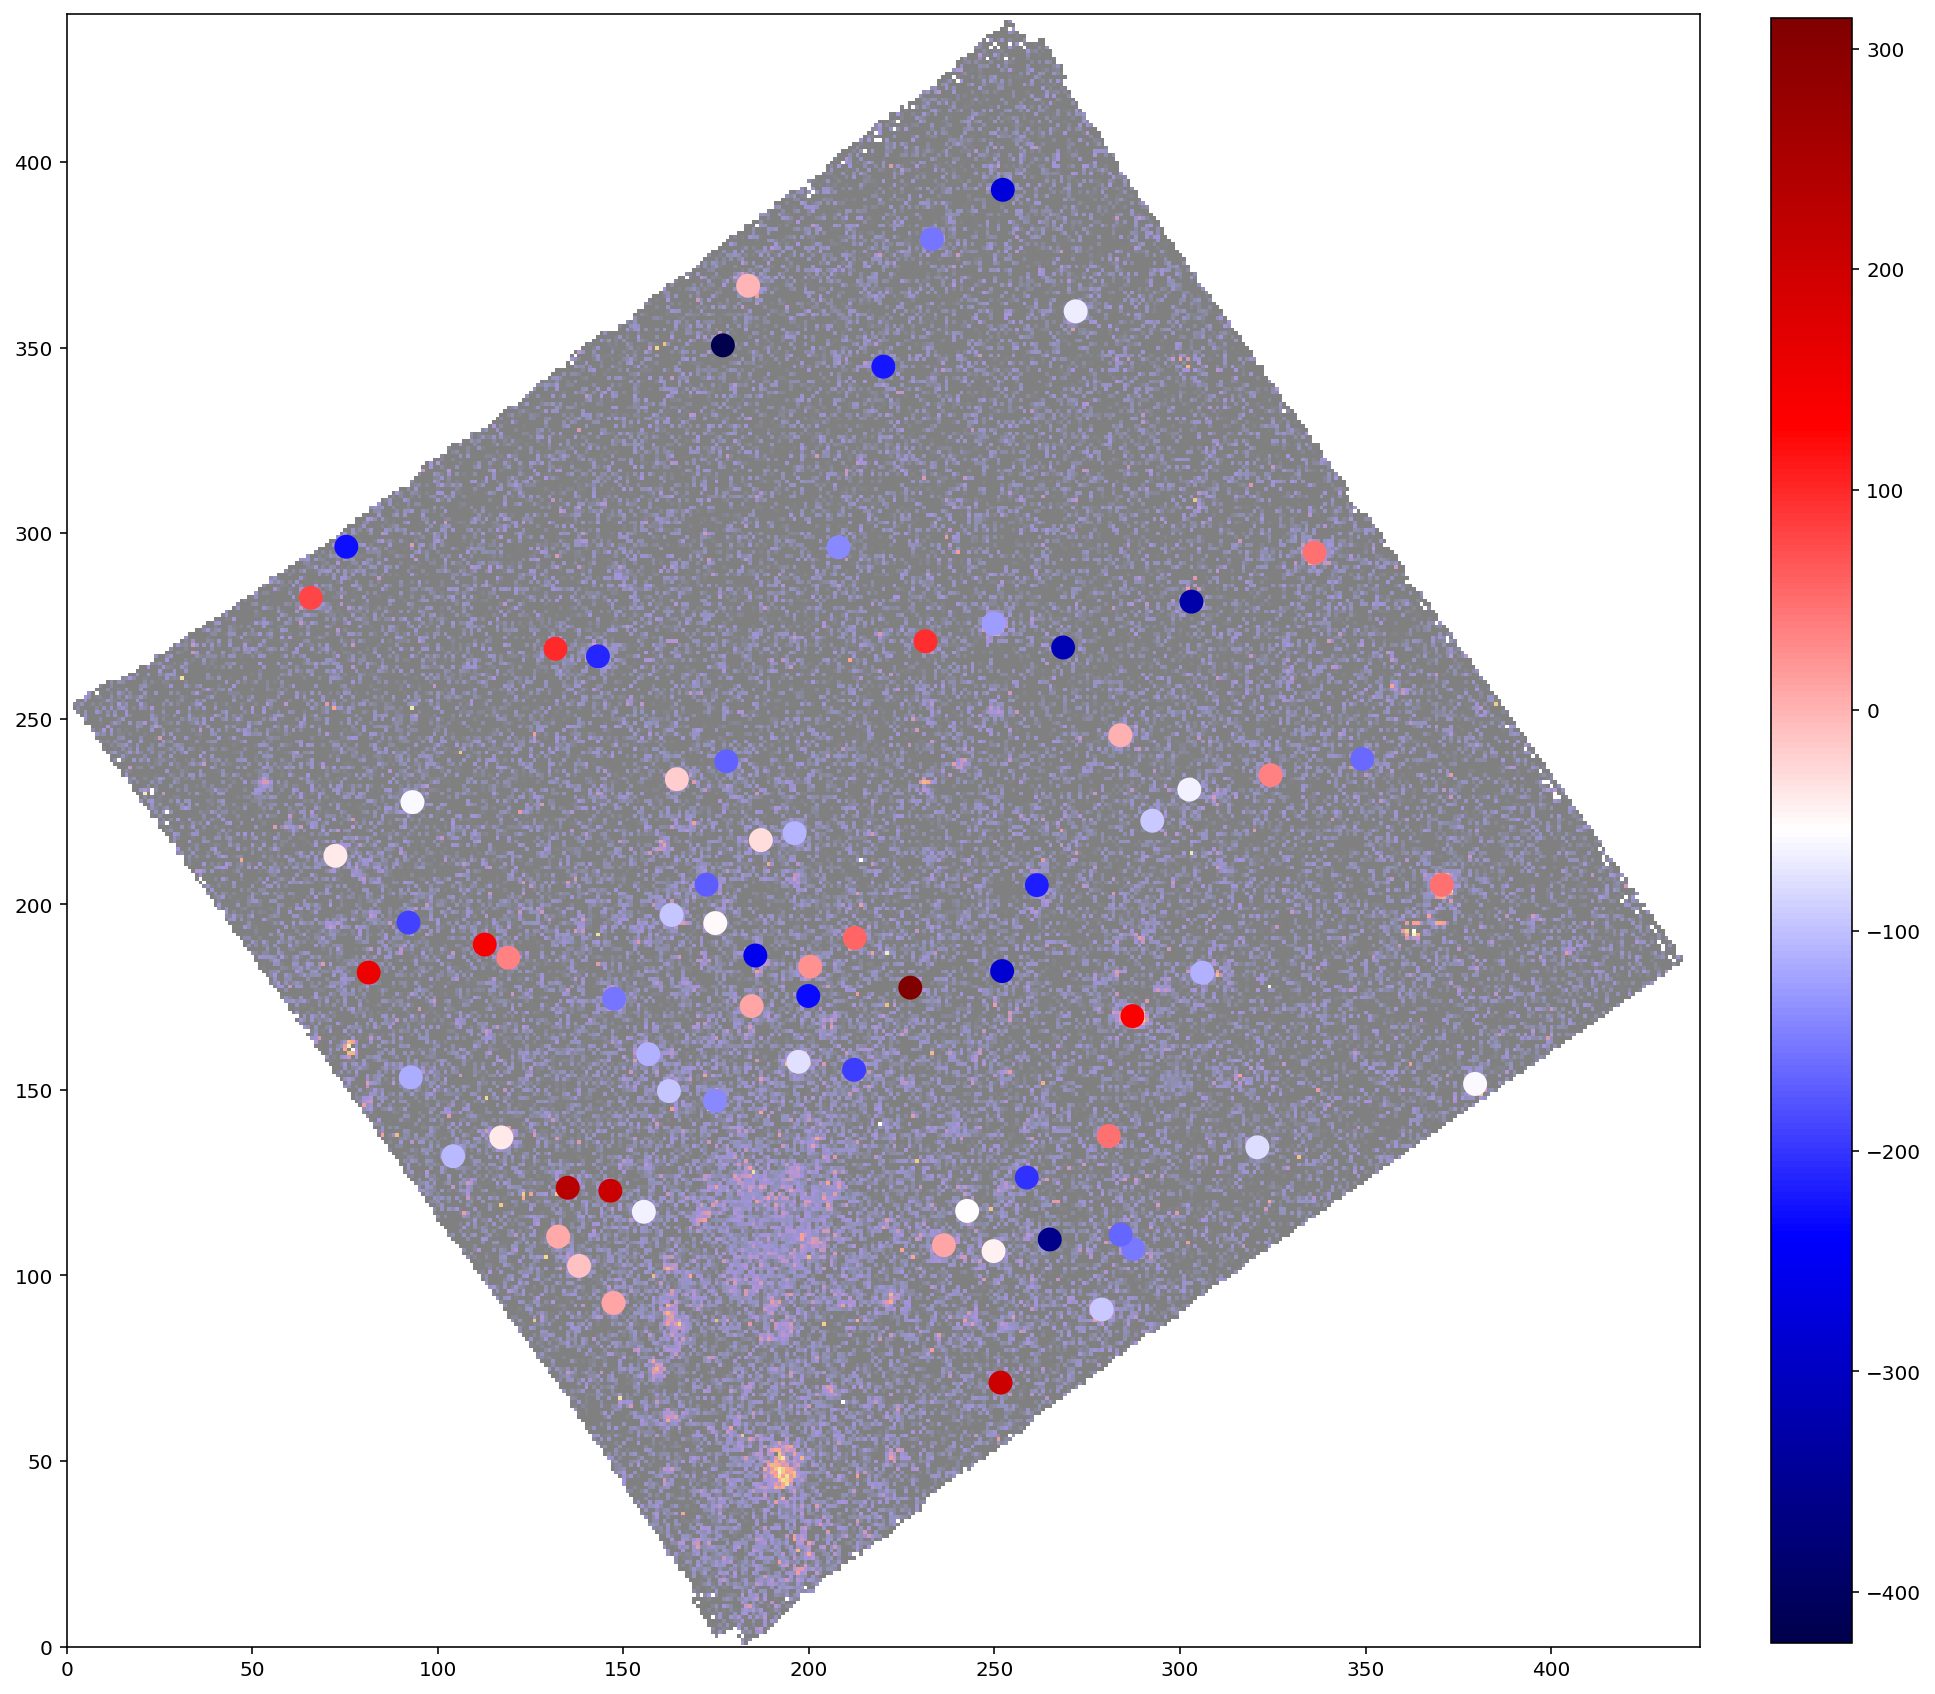

In [39]:
# Scatter plot the x y locations of PNe, colour coding them with their velocity
ind=PNe_df.loc[PNe_df["Filter"]=="Y"].index
positions = (x_PNe[ind], y_PNe[ind])
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8., alpha=0.5)
plt.scatter(x_PNe[ind], y_PNe[ind], c=PNe_df["V (km/s)"].loc[PNe_df["Filter"]=="Y"], cmap="seismic", s=120)
# plt.scatter(x_PNe, y_PNe, c=PNe_df["m 5007"], cmap="inferno_r", s=120)
if gal_name=="FCC219":
    plt.ylim(0,440)
    plt.xlim(0,440)
elif gal_name=="FCC193":
    plt.ylim(250,)
    plt.xlim(0,350)
elif gal_name == "FCC276":
    plt.xlim(310,)
cb = plt.colorbar(fraction=0.0455, pad=0.04)
# cb.set_label("$V_{[OIII]} \ (km \ s^{-1}$)", fontsize=20)
#plt.savefig("Plots/"+gal_name+"/PNe_velocity_dist_map.pdf")

In [4]:
hdulist_ppxf = fits.open(gal_name+"_data/"+gal_name+"center_ppxf_SPAXELS.fits")
v_star, s_star = hdulist_ppxf[1].data.V, hdulist_ppxf[1].data.SIGMA

In [12]:
np.median(v_star)

1804.5223675832533

In [27]:
## Velocity from files

hdulist_table = fits.open(gal_name+"_data/"+gal_name+"center_table.fits")
X_star, Y_star = hdulist_table[1].data.XBIN, hdulist_table[1].data.YBIN
flux_star = hdulist_table[1].data.FLUX

idx = flux_star.argmax()
X_star, Y_star = X_star-X_star[idx], Y_star-Y_star[idx]

hdulist_ppxf = fits.open(gal_name+"_data/"+gal_name+"center_ppxf_SPAXELS.fits")
v_star, s_star = hdulist_ppxf[1].data.V, hdulist_ppxf[1].data.SIGMA

cond = np.sqrt( (X_star)**2 + (Y_star)**2 ) <= 5.0
vsys = np.average(v_star[cond])
v_star = v_star-vsys

f_ind = PNe_df.loc[PNe_df["Filter"]=="Y"].index
if gal_name == "FCC167":
    gal_x_c = 230
    gal_y_c = 212
elif gal_name == "FCC219":
    gal_x_c = 190
    gal_y_c = 110
elif gal_name == "FCC193":
    gal_x_c = 170
    gal_y_c = 405

xpne, ypne = (x_PNe[f_ind]-gal_x_c)*0.2, (y_PNe[f_ind]-gal_y_c)*0.2

# Estimating the velocity dispersion of the PNe along the LoS
def sig_PNe(X_star,Y_star,v_stars,sigma,x_PNe,y_PNe,vel_PNe):

    d_PNe_to_skin = np.zeros(len(x_PNe))
    Vs_PNe = np.ones(len(x_PNe)) # Velocity of the closest star
    Ss_PNe = np.ones(len(x_PNe)) # Sigma for each PNe
    i_skin_PNe = []

    """ To estimate the velocity dispersion for PNe we need to
    extract the sigma of the closest stars for each PNe """

    for i in range(len(x_PNe)):
        r_tmp = np.sqrt((X_star-x_PNe[i])**2+(Y_star-y_PNe[i])**2)
        d_PNe_to_skin[i] = min(r_tmp)
        i_skin_PNe.append(r_tmp.argmin())

    Vs_PNe  = v_stars[i_skin_PNe]
    Ss_PNe  = sigma[i_skin_PNe]
    rad_PNe = np.sqrt(x_PNe**2+y_PNe**2)
    k = np.where(d_PNe_to_skin > 1.0)

    return rad_PNe, (vel_PNe-Vs_PNe)/Ss_PNe, k

rad_PNe, vel_ratio, k  = sig_PNe(X_star, Y_star, v_star, s_star, xpne, ypne, PNe_df["V (km/s)"].loc[PNe_df["Filter"]=="Y"])


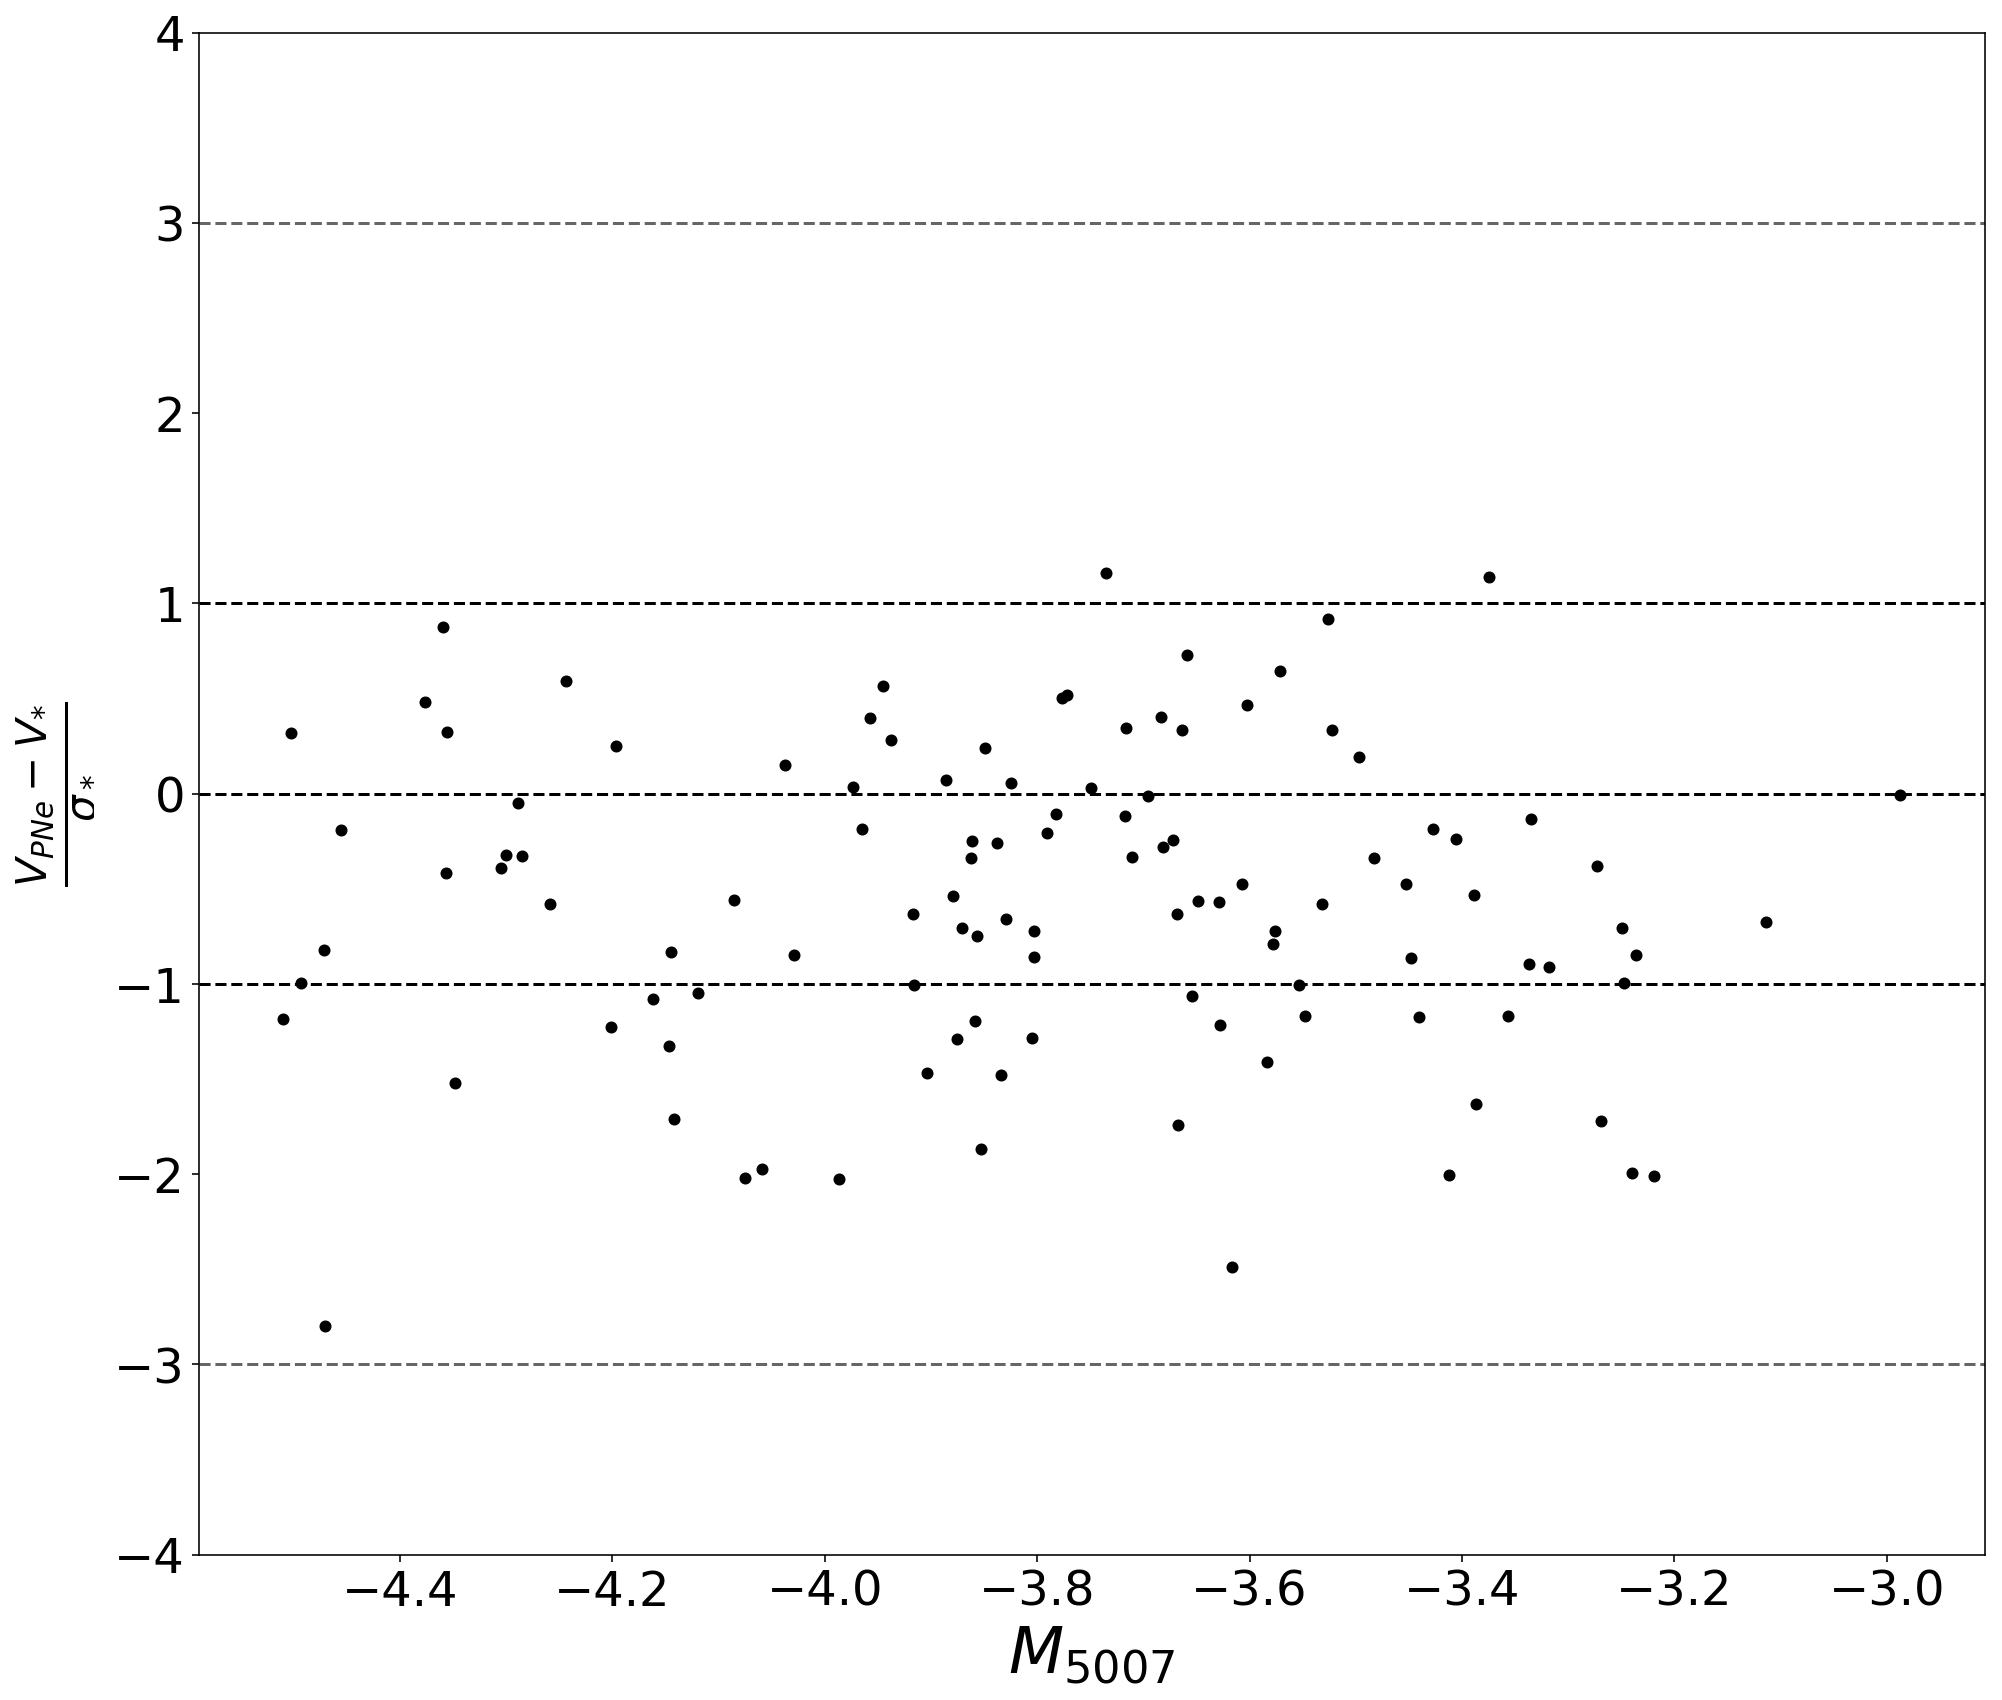

In [14]:
plt.figure(44, figsize=(16,14))
plt.clf()
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"], vel_ratio, s=25, c="k")
plt.xlabel("$M_{5007}$", fontsize=32)
plt.ylabel(r"$\frac{V_{PNe} - V_{*}}{\sigma_*}$", fontsize=30, labelpad=10)
plt.axhline(y=1, c="k", ls="dashed")
plt.axhline(y=3, c="k", ls="dashed", alpha=0.6)
plt.axhline(y=0, c="k", ls="dashed")
plt.axhline(y=-1, c="k", ls="dashed")
plt.axhline(y=-3, c="k", ls="dashed", alpha=0.6)
plt.ylim(-4,4)
plt.tick_params(labelsize = 24)
#plt.savefig("Plots/"+gal_name+"/"+gal_name+"_velocity_plot.pdf", bbox_inches='tight')

In [42]:
plt.figure(44, figsize=(16,14))
plt.clf()
plt.hist(vel_ratio[f_ind], bins=12)
plt.xlabel(r"$\frac{V_{PNe} - V_{*}}{\sigma_*}$", fontsize=32)
plt.ylabel("Number per bin", fontsize=30, labelpad=10)
plt.tick_params(labelsize = 24)
plt.xlim(-3,3)
plt.ylim(0,20)
#plt.savefig("Plots/"+gal_name+"/"+gal_name+"_velocity_plot.pdf", bbox_inches='tight')

NameError: name 'vel_ratio' is not defined

<Figure size 1152x1008 with 0 Axes>

In [ ]:
plt.figure(figsize=(16,16))
plt.scatter(X_star, Y_star, c=v_star, vmin=-150, vmax=150)
plt.scatter(xpne,ypne,c="r")
#plt.colorbar()

In [ ]:
## Tables for Marc
y_idx = PNe_df.loc[PNe_df["Filter"]=="Y"].index.values
n_idx = PNe_df.loc[PNe_df["Filter"]=="N"].index.values

tab_all = Table([PNe_df["PNe number"].values, 
                 PNe_df["A/rN"].values, 
                 PNe_df["Chi2"].values, 
                 A_2D_list[:,0], x_PNe, y_PNe, objects["peak"], mean_wave_list[:,0]], 
                names=("PNe #","fit A/rN", "Chi2", "A", "x", "y", "SEP A/rN", "best_fit_wave"))

tab_filter = Table([PNe_df["PNe number"].loc[PNe_df["Filter"]=="Y"], 
                    PNe_df["A/rN"].loc[PNe_df["Filter"]=="Y"].values, 
                    PNe_df["Chi2"].loc[PNe_df["Filter"]=="Y"].values, A_2D_list[y_idx,0], x_PNe[y_idx], y_PNe[y_idx], 
                    objects["peak"][y_idx], mean_wave_list[y_idx,0]], 
                   names=("PNe #","fit A/rN", "Chi2", "A", "x", "y", "SEP A/rN", "best_fit_wave"))

ascii.write(tab_all, "exported_data/"+gal_name+"/SEP_all_data_Table.dat", overwrite=True)
ascii.write(tab_filter, "exported_data/"+gal_name+"/SEP_filtered_data_Table.dat", overwrite=True)

# PSF determination

[58]
FWHM:  4.403274073597758 +/- 0.11109605874196711 (2.52%)
Beta:  6.831125954393097 +/- 3.2722437112477682 (47.90%)
LSF:  2.935944766674264 +/- 0.05402173092988879 (1.84%)




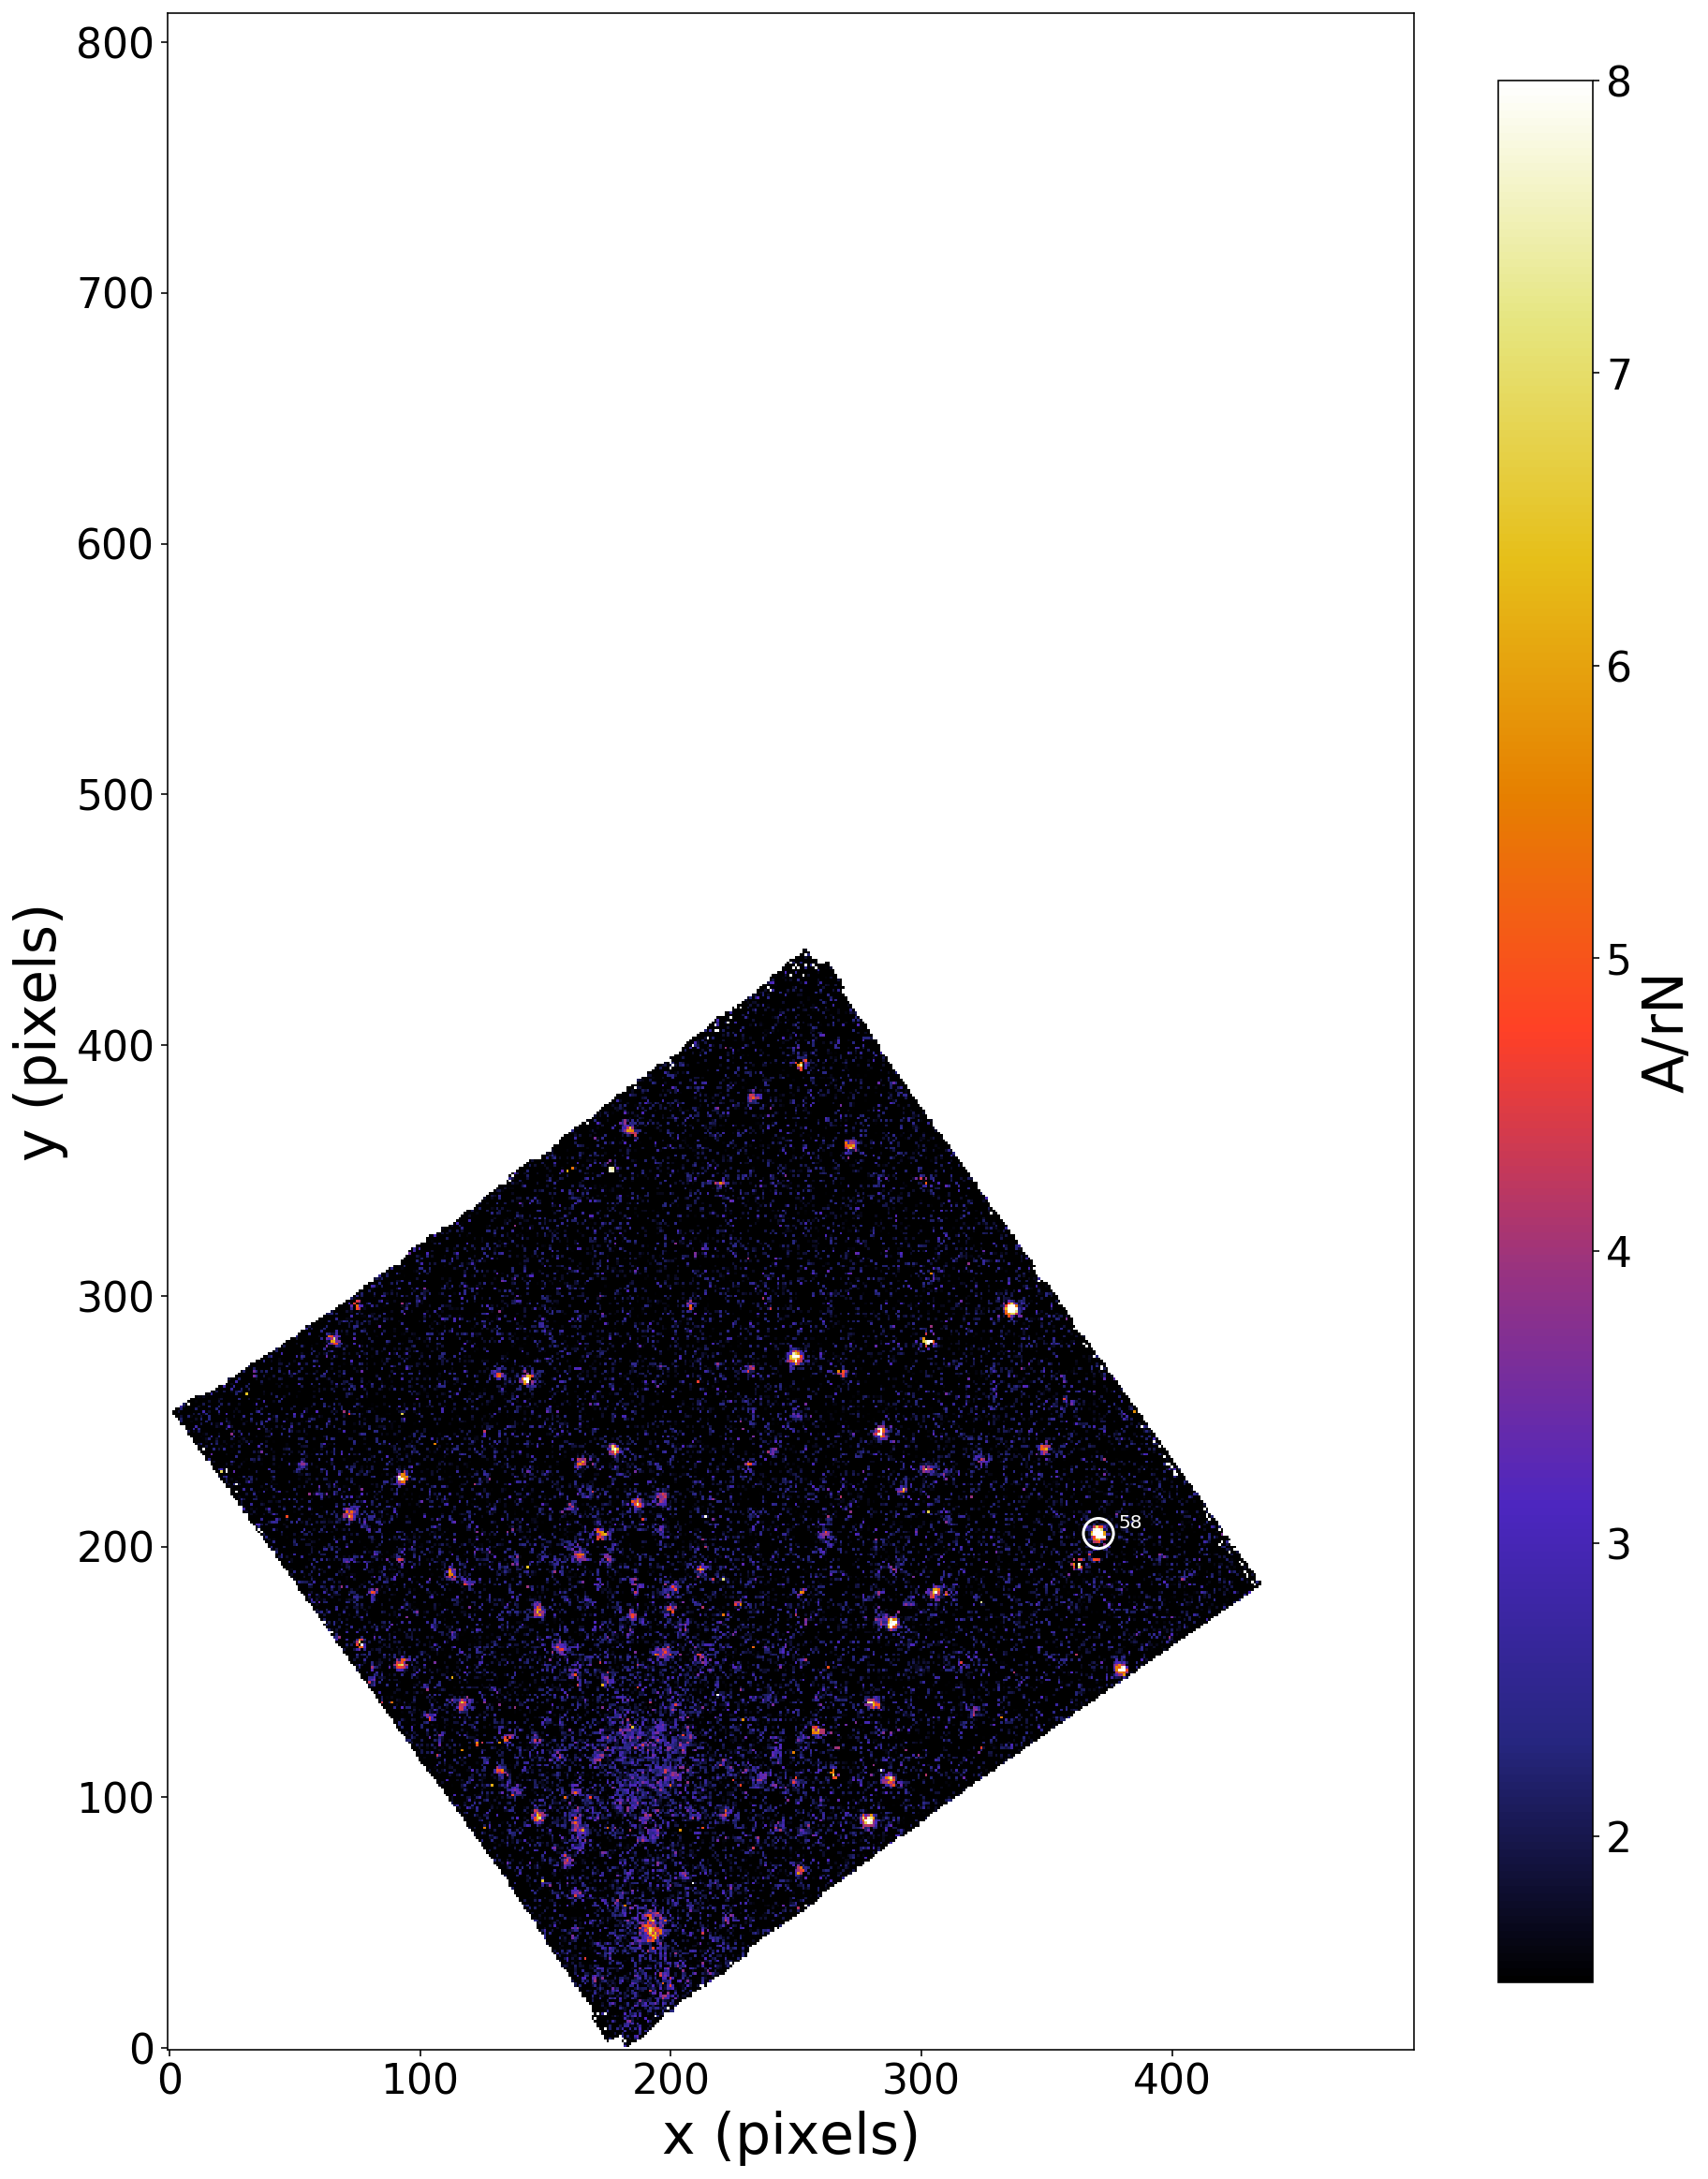

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 15147
    # variables        = 7
    chi-square         = 333296.254
    reduced chi-square = 22.0142836
    Akaike info crit   = 46836.8495
    Bayesian info crit = 46890.2284
[[Variables]]
    moffat_amp_000:  207.598052 +/- 5.39803505 (2.60%) (init = 200)
    x_000:           4.26655254 +/- 0.03672048 (0.86%) (init = 4.5)
    y_000:           3.54451662 +/- 0.03663520 (1.03%) (init = 4.5)
    wave_000:        5039.83199 +/- 0.02294707 (0.00%) (init = 5039.053)
    gauss_bkg_000:   0 (fixed)
    gauss_grad_000:  0 (fixed)
    FWHM:            4.40327407 +/- 0.11109606 (2.52%) (init = 4)
    beta:            6.83112595 +/- 3.27224371 (47.90%) (init = 2.5)
    LSF:             2.93594477 +/- 0.05402173 (1.84%) (init = 2.81)
None


In [38]:
### Single Run PSF Fitter
#sel_PNe = PNe_df.nsmallest(4, "m 5007").index.values
if gal_name == "FCC167":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] !=119].nlargest(2, "A/rN").index.values
elif gal_name == "FCC219":
    sel_PNe = [58]#PNe_df.loc[PNe_df["Filter"]=="Y"].loc[(PNe_df["PNe number"] != 48) & (PNe_df["PNe number"] != 26)].nlargest(5, "A/rN").index.values
elif gal_name == "FCC193":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 36].nlargest(6, "A/rN").index.values
elif gal_name == "FCC161":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(7, "A/rN").index.values#.loc[PNe_df["PNe number"] != 38].
elif gal_name == "FCC147":
    #sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 3].nlargest(5, "A/rN").index.values
    sel_PNe = [43,64,19,12,6]
elif gal_name == "FCC083":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[(PNe_df["PNe number"] != 42) & (PNe_df["PNe number"] != 63)].nlargest(8, "A/rN").index.values#.loc[PNe_df["PNe number"] != 38].
elif gal_name == "FCC255":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values
elif gal_name == "FCC249":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values
elif gal_name == "FCC310":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values
elif gal_name == "FCC277":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values
elif gal_name == "FCC276":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(6, "A/rN").index.values#.loc[PNe_df["PNe number"] != 21]
elif gal_name == "FCC184":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(9, "A/rN").index.values

#sel_PNe = PNe_df.loc[PNe_df["PNe number"] != 1].nlargest(10, "A/rN").index.values

#sel_PNe = [2]#[43,19,12,6]
print(sel_PNe)

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = obj_error_cube[sel_PNe]
PSF_params = Parameters()

def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.01)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("wave_{:03d}".format(n), value=mean, min=mean-15., max=mean+15.)
    PSF_params.add("gauss_bkg_{:03d}".format(n),  value=0.000, vary=False)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.000, vary=False)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5006.77*(1+z))    
    
PSF_params.add('FWHM', value=4.0,  min=0.01, vary=True)
PSF_params.add("beta", value=2.5,  min=0.01, vary=True) 
PSF_params.add("LSF",  value=2.81,)# min=0.01, vary=True)

PSF_results = minimize(PSF_residuals_3D, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, z), nan_policy="propagate")

print("FWHM: ", PSF_results.params["FWHM"].value, "+/-", PSF_results.params["FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["FWHM"].stderr / PSF_results.params["FWHM"].value)*100) )
print("Beta: ", PSF_results.params["beta"].value, "+/-", PSF_results.params["beta"].stderr, "({:3.2f}%)".format((PSF_results.params["beta"].stderr / PSF_results.params["beta"].value)*100) )
print("LSF: " , PSF_results.params["LSF"].value , "+/-", PSF_results.params["LSF"].stderr,  "({:3.2f}%)".format((PSF_results.params["LSF"].stderr  / PSF_results.params["LSF"].value)*100)  )
print("\n")

# Plot locations of PNe used for PSF
plt.figure(figsize=(20,20))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap",  vmin=1.5, vmax=8)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)

plt.xlabel("x (pixels)", fontsize=30)
plt.ylabel("y (pixels)", fontsize=30)

plt.tick_params(labelsize = 22)

#plt.xlim(0,450)
#plt.ylim(0,450)

for (i, item), n in zip(enumerate(x_y_list[sel_PNe]), sel_PNe):
    ax = plt.gca()
    circ = plt.Circle((item[0],item[1]),6, color="white",lw=1.5, fill=False)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(n, (item[0]+8, item[1]-4), color="white", size=10)
    else:
        ax.annotate(n, (item[0]+8, item[1]+2), color="white", size=10)

plt.show()
print(report_fit(PSF_results, show_correl=False))


# Comparison with literature

In [61]:
gal_hdulist = fits.open(gal_name+"_data/"+gal_name+"center.fits")

x_y_list = np.load("exported_data/"+gal_name+"/PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

hdr_wcs = gal_hdulist[1].header
wcs_obj = WCS(hdr_wcs, naxis=2)

for i in np.arange(0, len(x_PNe)):
    Ra_Dec = utils.pixel_to_skycoord(x_PNe[i],y_PNe[i], wcs_obj).to_string("hmsdms").split()
    PNe_df.loc[i,"Ra (J2000)"] = Ra_Dec[0]
    PNe_df.loc[i,"Dec (J2000)"] = Ra_Dec[1]

## FCC167

In [51]:
c = ascii.read("NGC1380_PNe_from_paper.txt", data_start=1)
lit_RA = list(c["RA"])
lit_Dec = list(c["Dec"])
lit_m = np.array(c["mag"])

x_y_lit = np.ones((len(x_PNe),2))
for i in np.arange(0, len(lit_RA)):
    x_y_lit[i] = utils.skycoord_to_pixel(SkyCoord(ra=Angle(lit_RA[i], u.hourangle), dec=Angle(lit_Dec[i], u.deg), frame="fk5"), wcs_obj)

smallest_sep = []
for r,d in zip(lit_RA, lit_Dec):
    sepa = []
    for r1,d1 in zip(PNe_df["Ra (J2000)"], PNe_df["Dec (J2000)"]):
        c1 = SkyCoord(Angle(r, u.hourangle), Angle(d, u.deg), frame="fk5")
        c2 = SkyCoord(Angle(r1, u.hourangle), Angle(d1, u.deg), frame="fk5")
        sepa.append(c1.separation(c2).degree)
    smallest_sep.append(sepa)
    
diff = np.array([np.min(smallest_sep[i]) for i in range(0, len(smallest_sep))])
potential_diff = diff[diff<0.001]
print(potential_diff)
print(np.where(diff<0.001))

indx =np.array(([np.squeeze(np.where(smallest_sep[i] == np.min(smallest_sep[i]))) for i in range(0, len(smallest_sep))]))
#print(indx[[0,2,6,20]])
#print(lit_m[[0,2,6,20]])
PNe_df.loc[indx[np.where(diff<0.001)]]

[0.0001147  0.00099191 0.00032357 0.00041565 0.00027396]
(array([ 0,  1,  2,  6, 20]),)


PNe number      Ra (J2000)      Dec (J2000)    V (km/s)     m 5007  \
105         105  03h36m27.6516s  -34d58m00.2475s -162.572831  27.870699   
107         107  03h36m28.2602s  -34d57m57.1921s -145.570366  27.659577   
93           93  03h36m28.0016s  -34d58m14.8502s -110.938476  26.852739   
66           66  03h36m26.3736s  -34d58m29.4728s   12.141866  27.159870   
85           85  03h36m25.6455s  -34d58m18.9537s  -99.128209  27.535839   

       M 5007   [OIII] Flux M 5007 error      A/rN rad D    redchi Filter  \
105 -3.760980  2.268404e-17          NaN  4.177366   NaN  1.031042      Y   
107 -3.972102  2.755302e-17          NaN  3.353217   NaN  1.022538      Y   
93  -4.778940  5.793010e-17          NaN  7.411431   NaN  1.022187      Y   
66  -4.471809  4.365681e-17          NaN  6.180837   NaN  1.026172      Y   
85  -4.095841  3.087909e-17          NaN  5.811747   NaN  1.032757      Y   

     [OIII]/Hb    Flux error  F[OIII] err percent    OIII/Ha  
105   6.335699  1.300286e-18             5.732164   4.407040  
107   4.995429  1.805498e-18             6.552813   0.000000  
93    3.922341  2.214920e-18             3.823436   9.842604  
66    8.170374  1.930254e-18             4.421427   8.790239  
85    5.690026  1.385662e-18             4.487380  11.094197

In [68]:
print(PNe_df["[OIII] Flux"].loc[indx[[ 0,  1,  2,  6, 20]]].values)
print([27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866])
print(lit_m[[ 0,  1,  2,  6, 20]])
print(np.abs([27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866] - lit_m[[ 0,  1,  2,  6, 20]]))

[2.26840373e-17 2.75530161e-17 5.79301040e-17 4.36568107e-17
 3.08790930e-17]
[27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866]
[26.585 26.718 26.725 26.809 27.203]
[0.53696    0.94157713 0.12773923 0.35086999 0.33283866]


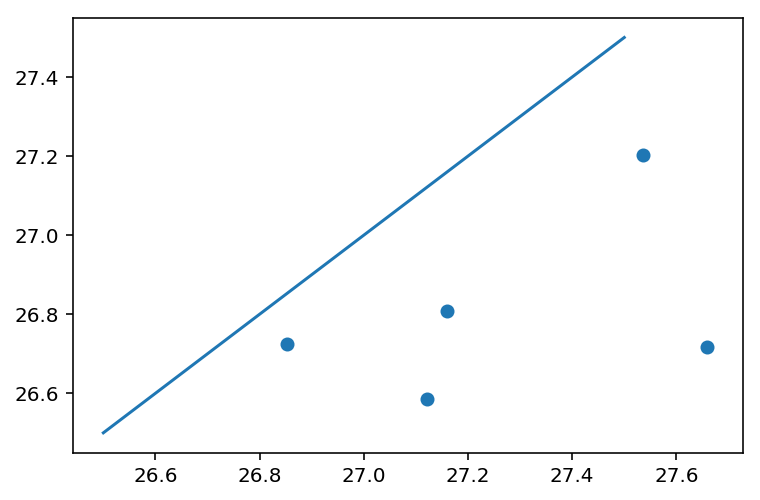

In [61]:
plt.scatter([27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866], lit_m[[ 0,  1,  2,  6, 20]] )
plt.plot(np.arange(26.5,28), np.arange(26.5,28))

Text(0, 0.5, 'Dec')

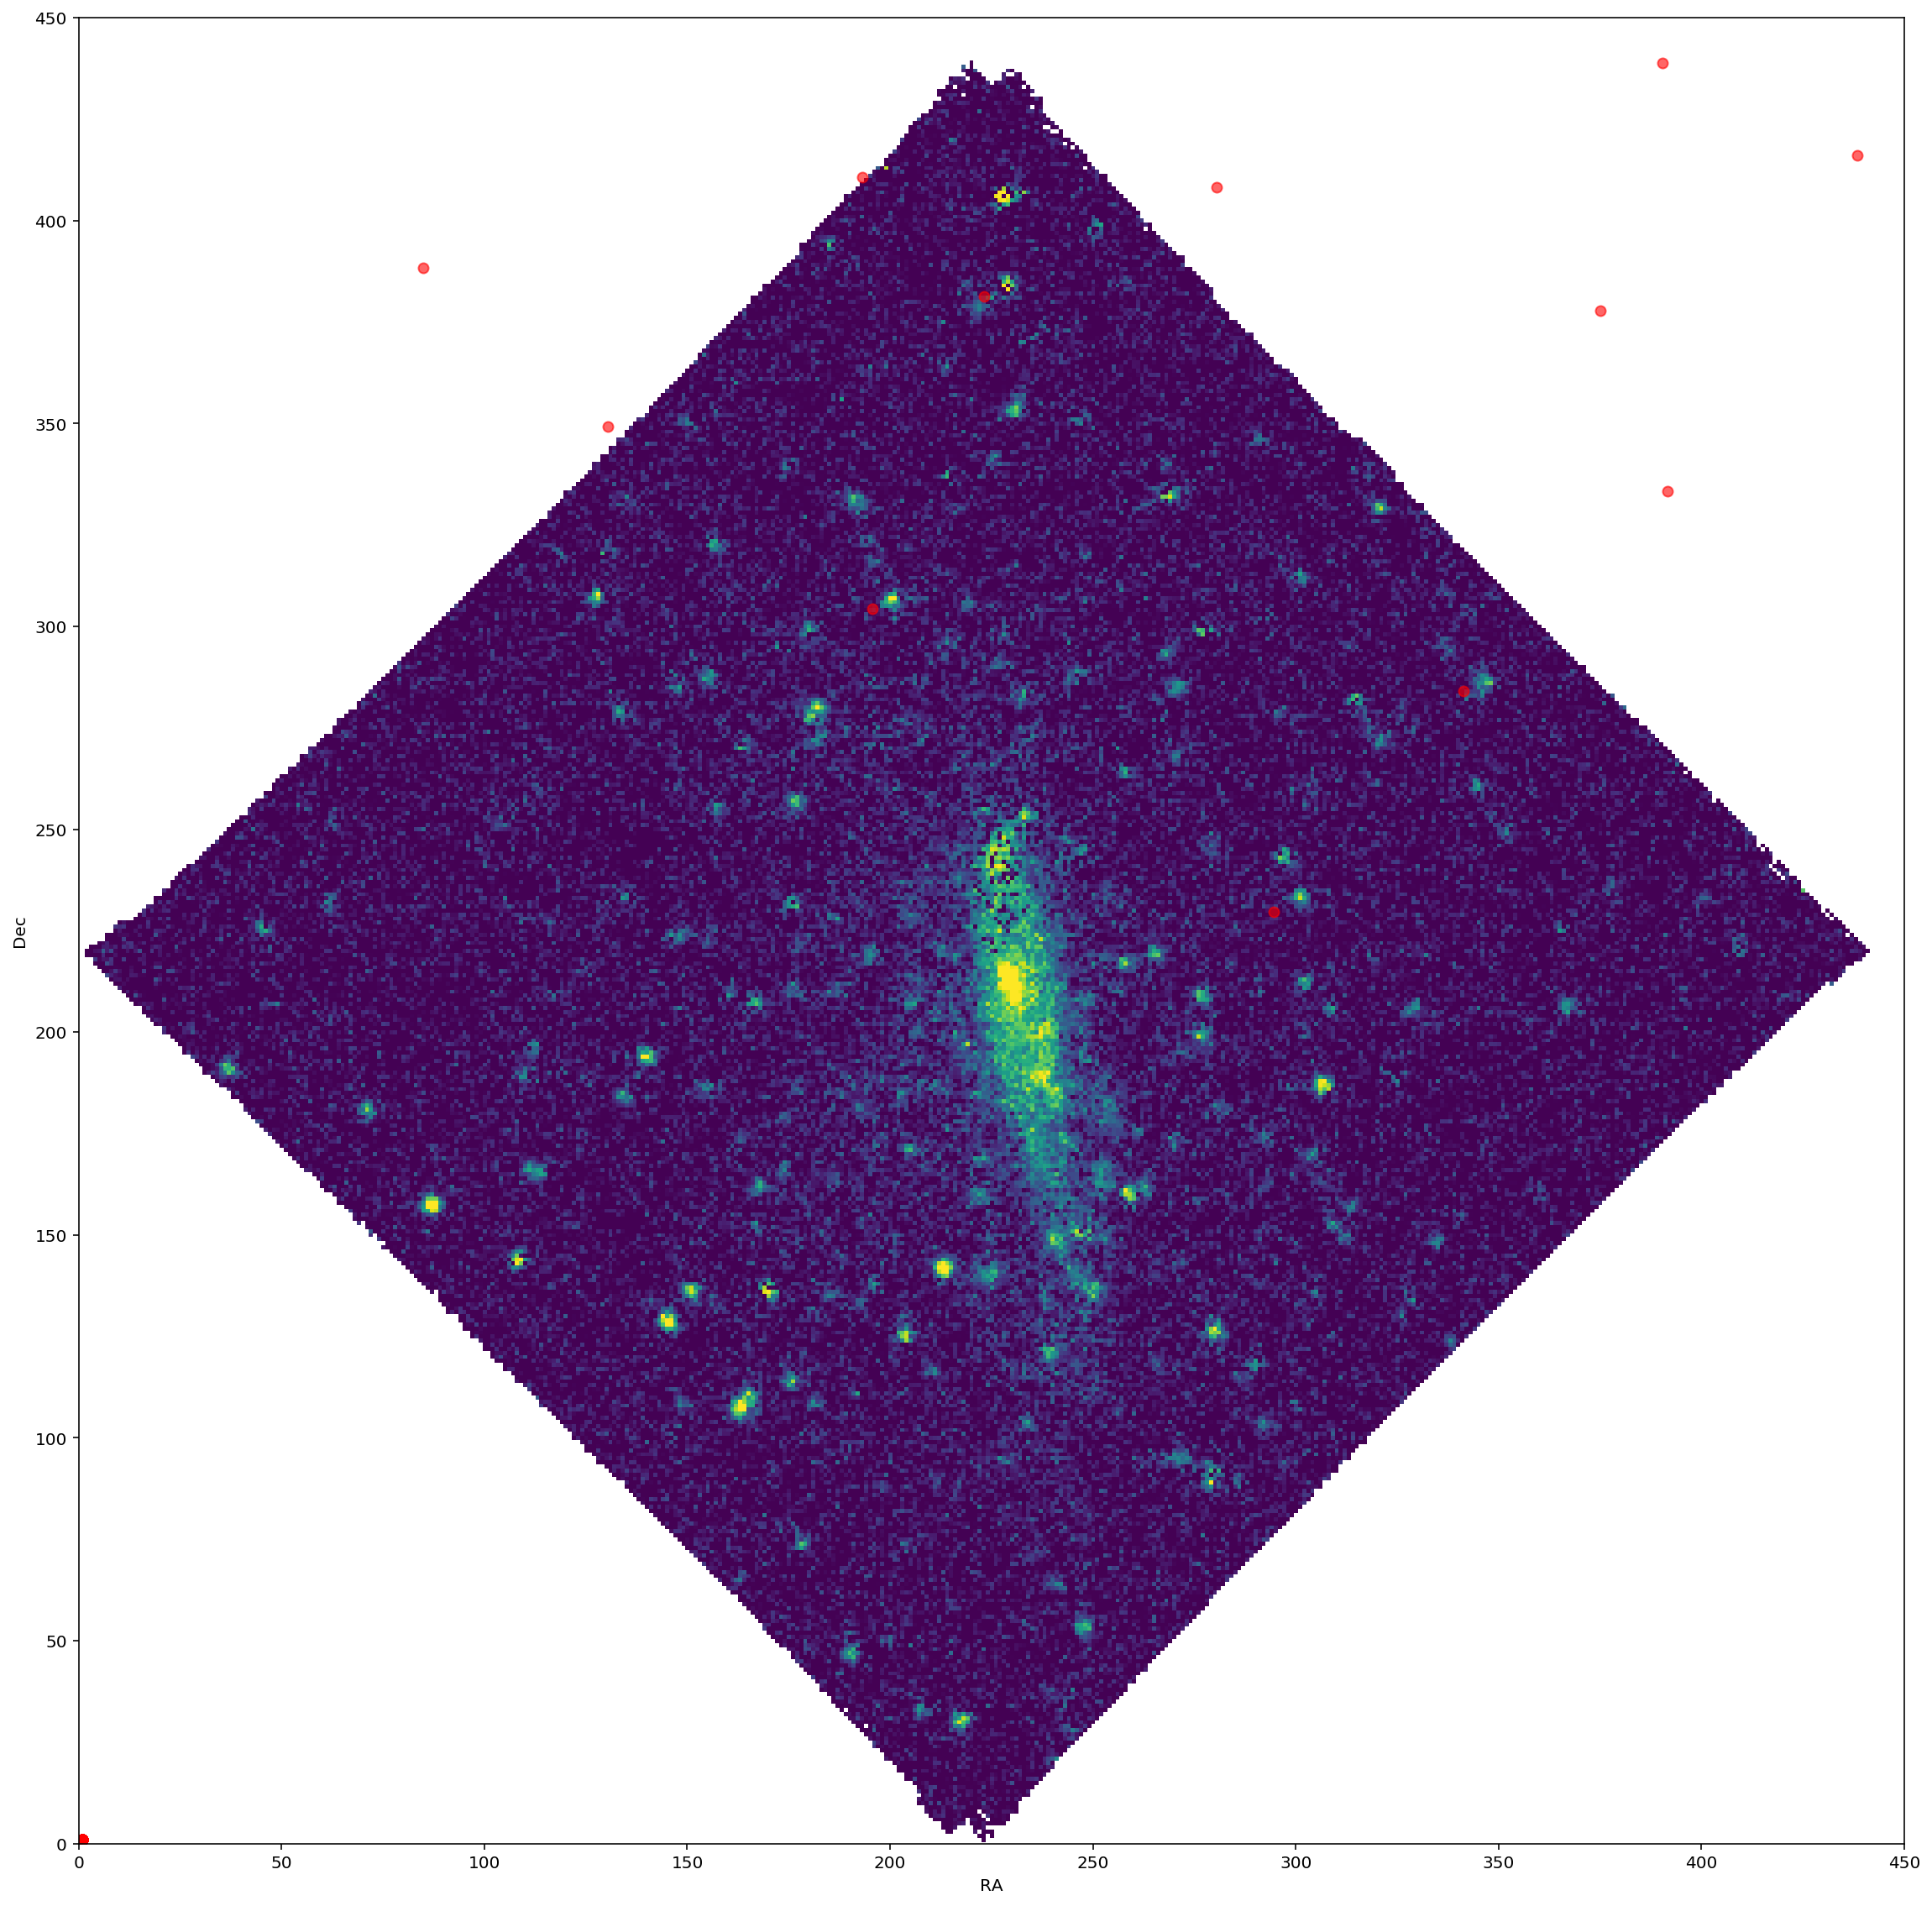

In [40]:
gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)


fig = plt.figure(figsize=(20,20))
# fig.add_subplot(111, projection=wcs_obj)
plt.imshow(A_rN_plot_shape, origin='lower', cmap=plt.cm.viridis, vmin=1, vmax=8)
plt.scatter([x_y_lit[i][0] for i in range(len(x_y_lit))], [x_y_lit[i][1] for i in range(len(x_y_lit))], color="r", alpha=0.6)
plt.xlim(0,450)
plt.ylim(0,450)
plt.xlabel('RA')
plt.ylabel('Dec')

## FCC219

[0.00027301 0.00022469 0.00024347 0.00022385 0.00019106 0.00024302]
(array([ 2,  4,  7, 31, 38, 43]),)
[ 61  65 104 115 106 108]


PNe number      Ra (J2000)      Dec (J2000)    V (km/s)     m 5007  \
61           61  03h38m49.0891s  -35d35m23.1532s -345.749869  27.594658   
65           65  03h38m48.9907s  -35d35m22.6009s  259.714851  28.093634   
104         104  03h38m50.0742s  -35d35m05.5478s -355.745398  27.353643   
115         115  03h38m52.1549s  -35d34m51.6173s -451.130710  27.669189   
106         106  03h38m53.8059s  -35d35m02.6063s -259.321397  28.158646   
108         108  03h38m49.5297s  -35d35m02.8763s   19.354254  27.316820   

       M 5007   [OIII] Flux M 5007 error       A/rN rad D    redchi Filter  \
61  -3.613009  2.925075e-17          NaN   7.341989   NaN  1.004045      Y   
65  -3.114033  1.847339e-17          NaN   4.815129   NaN  1.016195      Y   
104 -3.854023  3.652100e-17          NaN   9.963678   NaN  1.000426      Y   
115 -3.538478  2.731017e-17          NaN   7.054721   NaN  1.005559      Y   
106 -3.049021  1.739970e-17          NaN   4.337599   NaN  1.173099      Y   
108 -3.890847  3.778087e-17          NaN  10.563127   NaN  0.990047      Y   

             Chi2    [OIII]/Hb    Flux error  m 5007 error  \
61   15208.266245    25.372080           NaN           NaN   
65   15392.299328  9228.714999  8.123179e-19      0.047790   
104  15153.451480    32.677308           NaN           NaN   
115  15231.197990    23.703255           NaN           NaN   
106  17768.931222    15.369281           NaN           NaN   
108  14996.239947     1.216463  1.039995e-18      0.029875   

     F[OIII] err percent  
61                   NaN  
65              4.397234  
104                  NaN  
115                  NaN  
106                  NaN  
108             2.752703

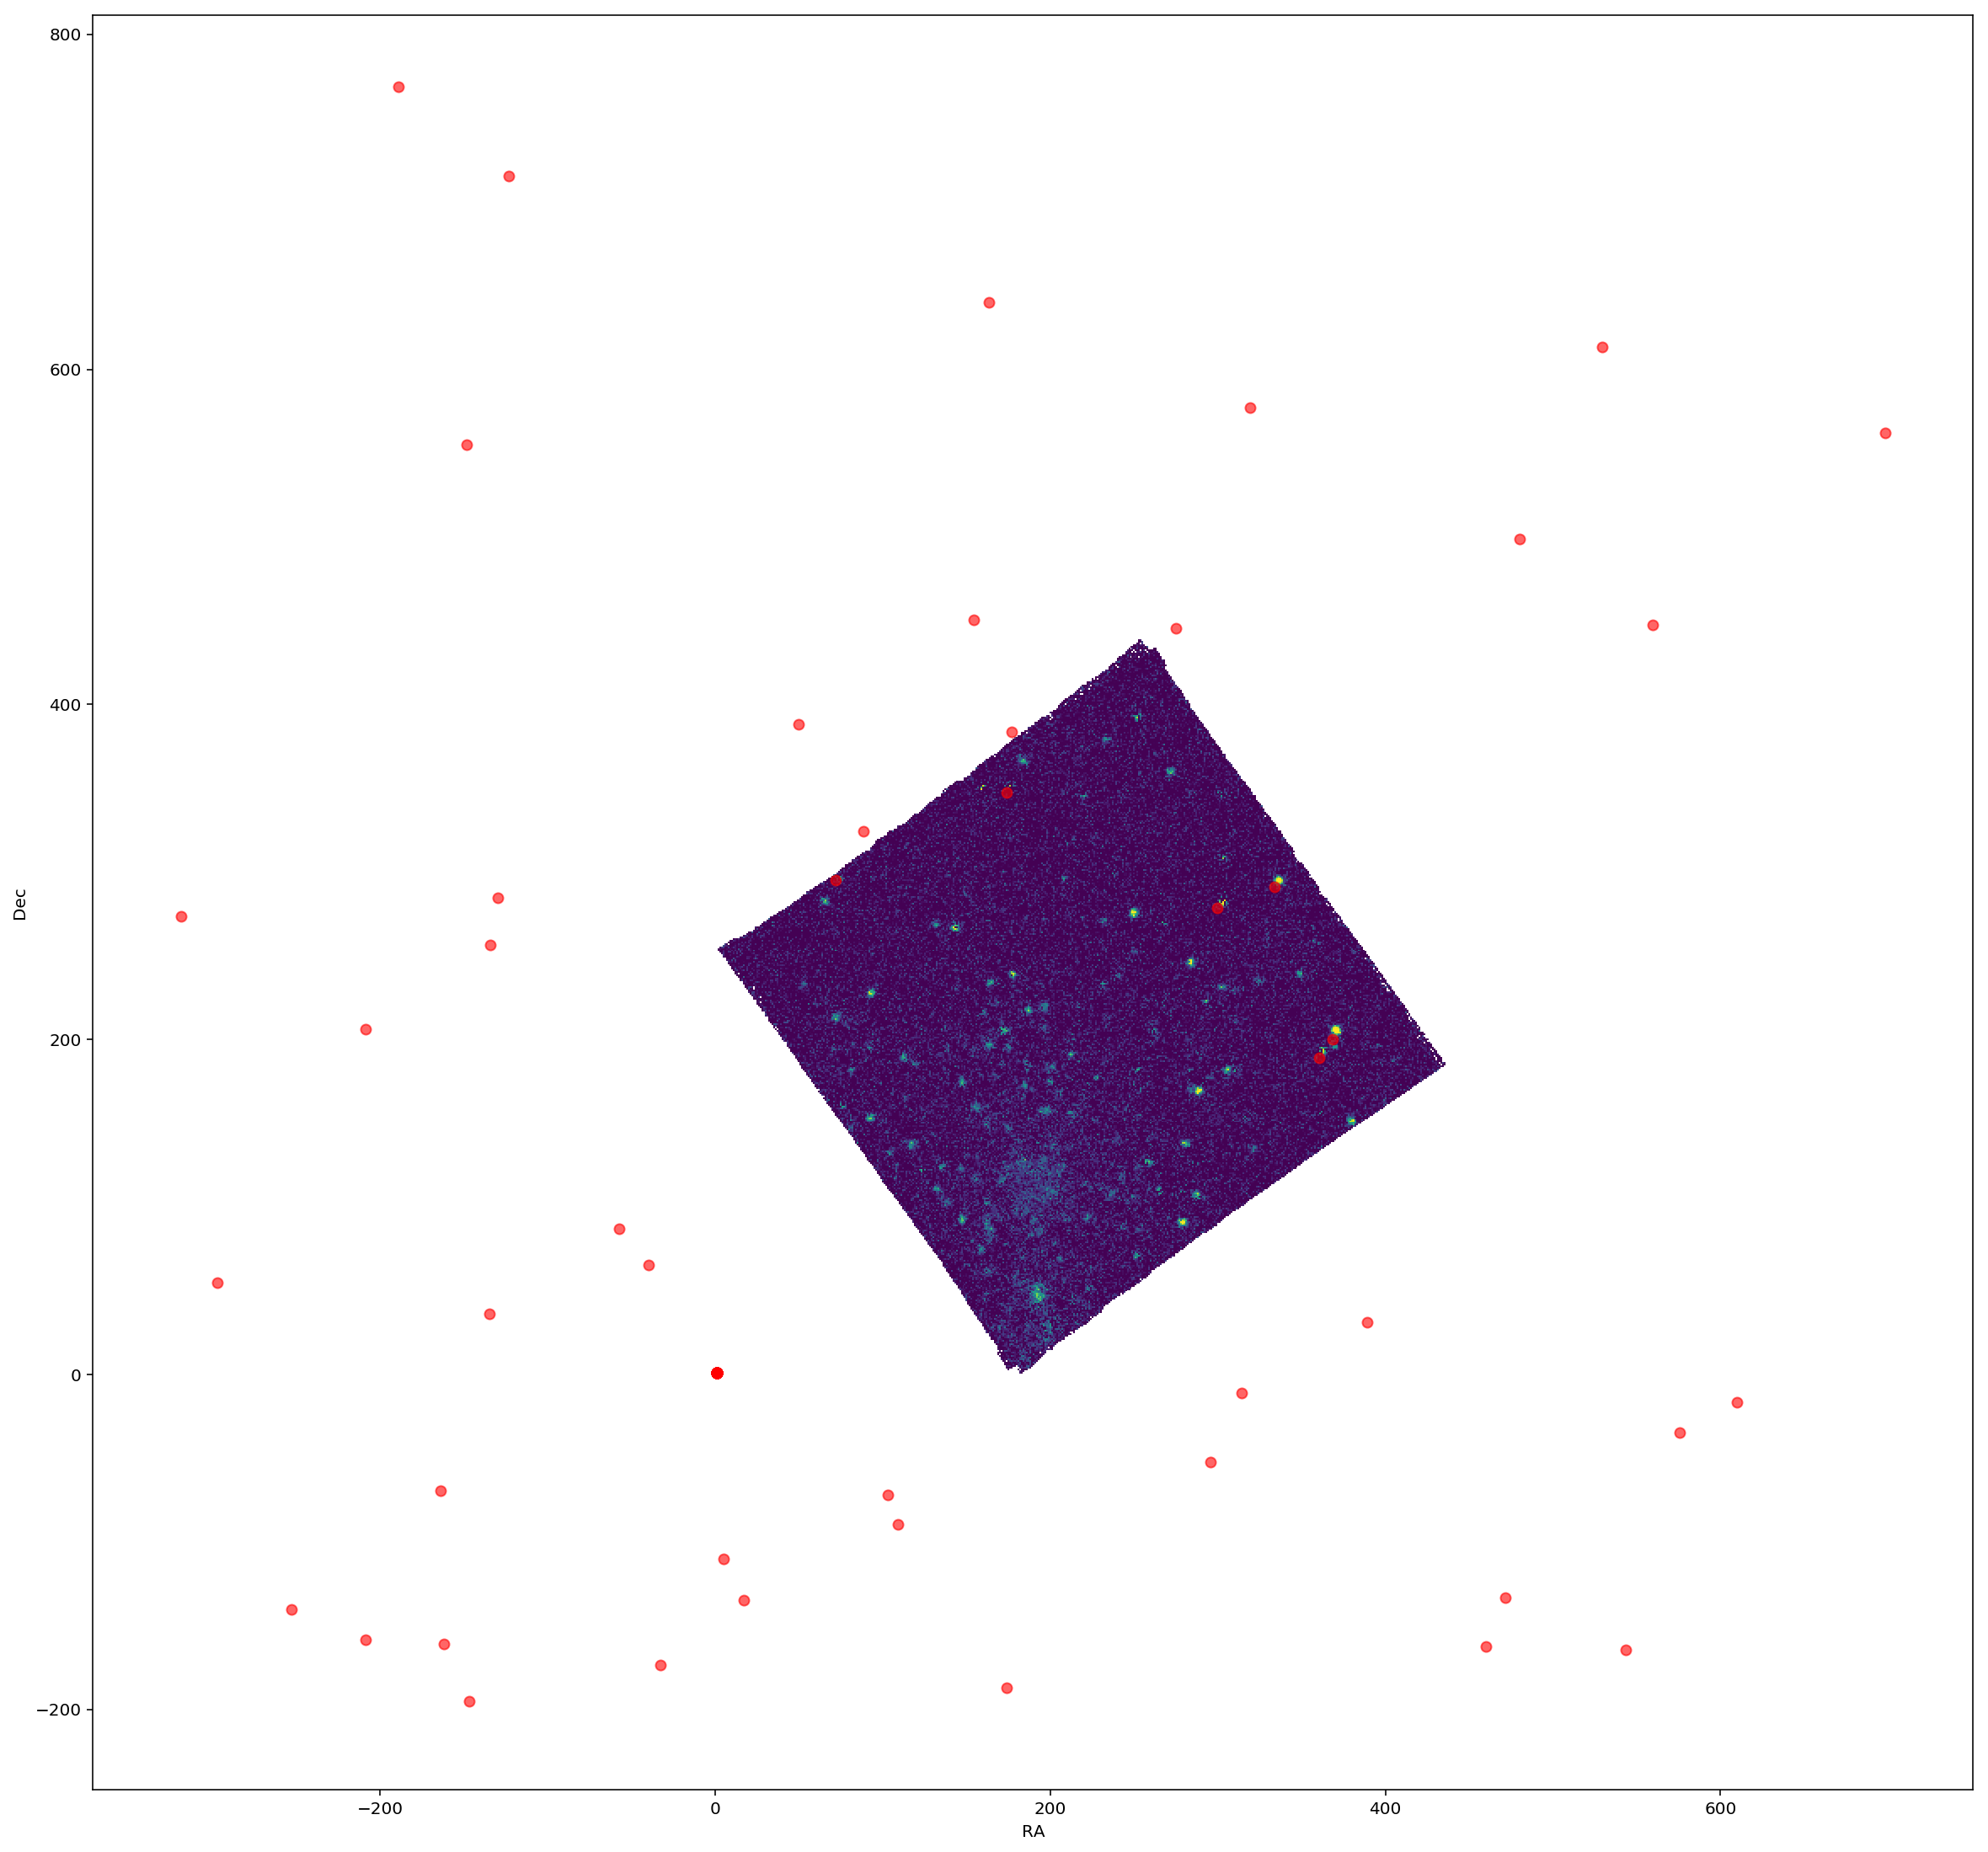

In [62]:
PNe_hdulist = fits.open("PNe1404.fit")
list_1404 = PNe_hdulist[1].data
list_1404 = list_1404[-47:]
RA_1404 =    [list_1404[i][7] for i in np.arange(0,len(list_1404))]
Dec_1404 =   [list_1404[i][8] for i in np.arange(0,len(list_1404))]
m5007_1404 = [list_1404[i][4] for i in np.arange(0,len(list_1404))]

x_y_lit = np.ones((len(x_PNe),2))
for i in np.arange(0, len(list_1404)):
    x_y_lit[i] = utils.skycoord_to_pixel(SkyCoord(ra=Angle(RA_1404[i], u.hourangle), dec=Angle(Dec_1404[i], u.deg), frame="fk5"), wcs_obj)


gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)


fig = plt.figure(figsize=(20,20))
# fig.add_subplot(111, projection=wcs_obj)
plt.imshow(A_rN_plot_shape, origin='lower', cmap=plt.cm.viridis, vmin=1, vmax=8)
plt.scatter([x_y_lit[i][0] for i in range(len(x_y_lit))], [x_y_lit[i][1] for i in range(len(x_y_lit))], color="r", alpha=0.6)
#plt.xlim(0,500)
#plt.ylim(0,500)
plt.xlabel('RA')
plt.ylabel('Dec')


smallest_sep = []
for r,d in zip(RA_1404, Dec_1404):
    sepa = []
    for r1,d1 in zip(PNe_df["Ra (J2000)"], PNe_df["Dec (J2000)"]):
        c1 = SkyCoord(Angle(r, u.hourangle), Angle(d, u.deg), frame="fk5")
        c2 = SkyCoord(Angle(r1, u.hourangle), Angle(d1, u.deg), frame="fk5")
        sepa.append(c1.separation(c2).degree)
    smallest_sep.append(sepa)
    
diff = np.array([np.min(smallest_sep[i]) for i in range(0, len(smallest_sep))])
potential_diff = diff[diff<0.001]
print(potential_diff)
print(np.where(diff<0.001))

indx =np.array(([np.squeeze(np.where(smallest_sep[i] == np.min(smallest_sep[i]))) for i in range(0, len(smallest_sep))]))
print(indx[np.where(diff<0.001)])
PNe_df.iloc[indx[np.where(diff<0.001)]]

Text(0.5, 0, '$m_{5007} $ values MUSE')

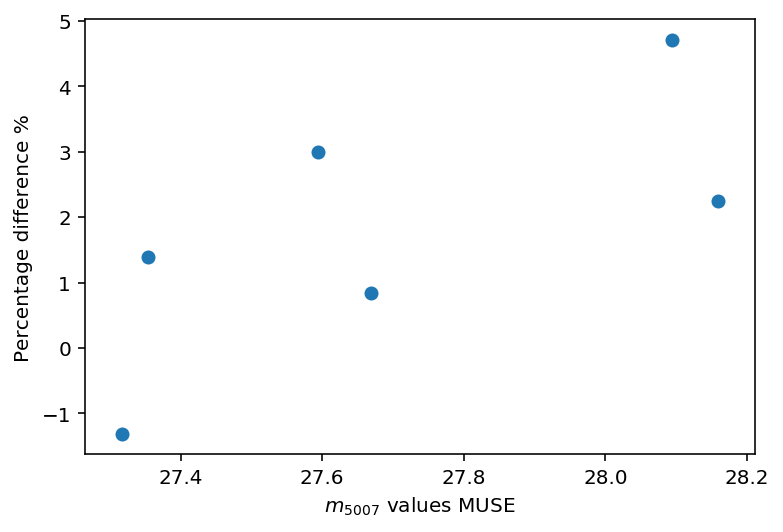

In [70]:
x_dat = PNe_df["m 5007"].iloc[indx[np.where(diff<0.001)]].values
y_dat = np.array(m5007_1404)[np.where(diff<0.001)]

y_d = 100*((x_dat - y_dat)/y_dat)
x_d = 100*((y_dat-x_dat)/x_dat)

plt.scatter(x_dat, y_d)
plt.ylabel("Percentage difference %")
plt.xlabel("$m_{5007} $ values MUSE")

## PNLF

/auto/data/tspriggs/Github/MUSE_PNe_fitting/PNLF.py:60: RuntimeWarning: invalid value encountered in true_divide
  u2 = (d/(9.0*mad))**2  # c = 9
/auto/data/tspriggs/Github/MUSE_PNe_fitting/PNLF.py:61: RuntimeWarning: invalid value encountered in less
  good = u2 < 1.0
/auto/data/tspriggs/Github/MUSE_PNe_fitting/PNLF.py:65: RuntimeWarning: invalid value encountered in double_scalars
  sigma = np.sqrt(num/(den*(den - 1.0)))  # see note in above reference
/auto/data/tspriggs/Github/MUSE_PNe_fitting/PNLF.py:91: RuntimeWarning: invalid value encountered in less
  image[image<0] = 0
/auto/data/tspriggs/Github/MUSE_PNe_fitting/PNLF.py:152: RuntimeWarning: divide by zero encountered in true_divide
  ratio_counter_cen[i] = (np.nansum(image[((a / Noise_mask_cen) > peak)])/np.nansum(image)).astype(np.float128)
/auto/data/tspriggs/Github/MUSE_PNe_fitting/PNLF.py:152: RuntimeWarning: invalid value encountered in greater
  ratio_counter_cen[i] = (np.nansum(image[((a / Noise_mask_cen) > peak)])/np.n

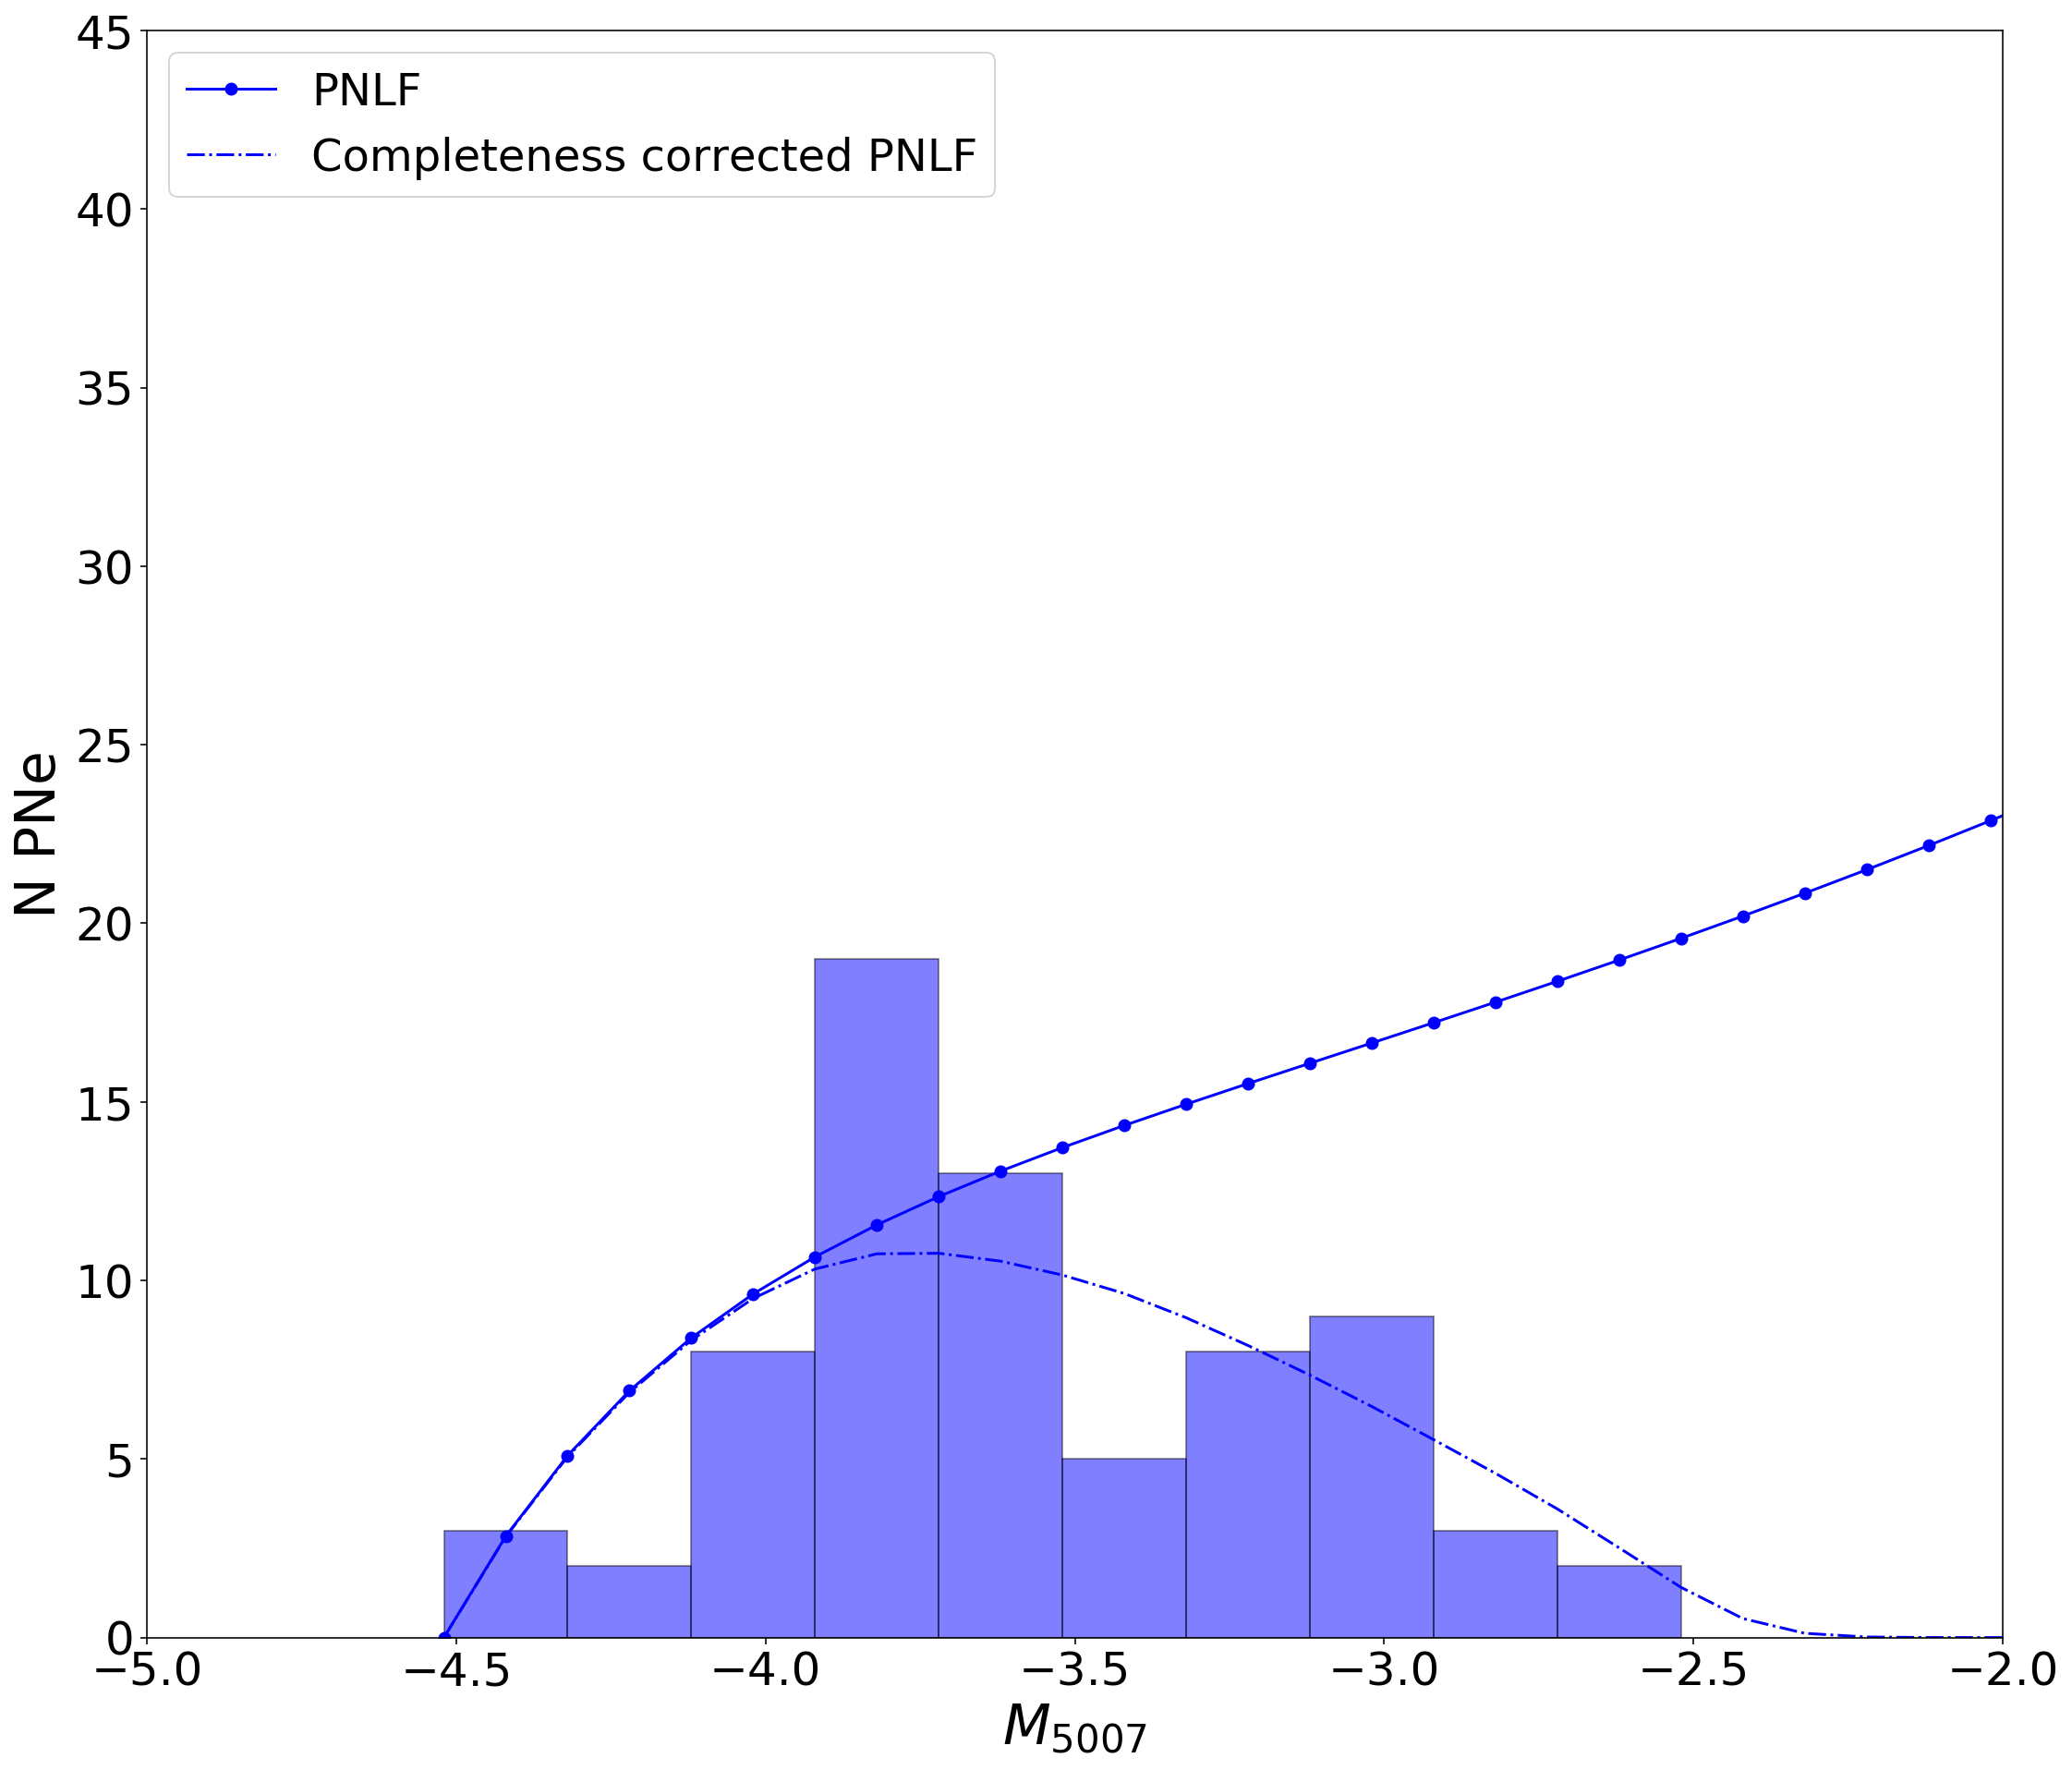

In [40]:
x_data_cen, y_data_cen, map_cen, aux = open_data(gal_name)

image, wave = reconstructed_image(gal_name)
image = image.reshape([y_data_cen,x_data_cen])

mag = PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"].values

# Total PNLF
PNLF, PNLF_corr, Abs_M = completeness(gal_name, mag, PNe_multi_params, Dist_est, image, peak=3.,
                                      gal_mask_params=gal_mask, star_mask_params=star_mask, 
                                      mask=True, c1=0.307 ) # Estimating the completeness for the central pointing # Dist_est
#PNLF_plus, PNLF_corr_plus, Abs_M_plus = completeness(gal_name, mag, PNe_multi_params, D_est_plus, image, 2.75, mask=True ) # Estimating the completeness for the central pointing
#PNLF_min, PNLF_corr_min, Abs_M_min = completeness(gal_name, mag, PNe_multi_params, D_est_plus, image, 2.75, mask=True ) # Estimating the completeness for the central pointing

# Getting the normalisation
total_norm = np.sum(np.abs(PNLF_corr))*abs(Abs_M[1]-Abs_M[0])
#total_norm_plus = np.sum(PNLF_corr_plus)*abs(Abs_M_plus[1]-Abs_M_plus[0])
#total_norm_min = np.sum(PNLF_corr_min)*abs(Abs_M_min[1]-Abs_M_min[0])

# Scaling factor
scal = len(mag)/total_norm
#scal_plus = len(mag)/total_norm_plus
#scal_min = len(mag)/total_norm_min

# Constraining to -2.0 in magnitude
idx = np.where(Abs_M <= -2.0)
# Total number of PNe
tot_N_PNe = np.sum(PNLF_corr[idx]*scal)*abs(Abs_M[1]-Abs_M[0])
#tot_N_PNe_plus = np.sum(PNLF_corr_plus[idx]*scal_plus)*abs(Abs_M_plus[1]-Abs_M_plus[0])
#tot_N_PNe_min = np.sum(PNLF_corr_min[idx]*scal_min)*abs(Abs_M_min[1]-Abs_M_min[0])

plt.figure(figsize=(18,16))
#plt.figure(figsize=(12,10))
binwidth = 0.2
hist = plt.hist(mag, bins=np.arange(min(mag), max(mag) + binwidth, binwidth), edgecolor="black", linewidth=0.8, alpha=0.5, color='blue')

ymax = max(hist[0])

plt.plot(Abs_M, PNLF*scal*binwidth, '-', color='blue', marker="o", label="PNLF")
plt.plot(Abs_M, PNLF_corr*scal*binwidth,'-.', color='blue', label="Completeness corrected PNLF")

plt.xlabel('$M_{5007}$', fontsize=30)
plt.ylabel('N PNe', fontsize=30)
#plt.yticks(np.arange(0,ymax+4, 5))

plt.xlim(-5.0,-2.0); plt.ylim(0,45);
plt.tick_params(labelsize = 25)

#plt.axvline(PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"].values.min() - 31.63)
plt.legend(loc=2, fontsize=24)
#plt.savefig("Plots/"+gal_name+"/"+gal_name+"_PNLF.pdf", bbox_inches='tight')
#plt.savefig("Plots/"+gal_name+"/"+gal_name+"_PNLF.png", bbox_inches='tight')

In [41]:
step = Abs_M[1]-Abs_M[0]
N_PNe = np.sum(PNLF[:25]*scal*step)
print("Number of PNe from PNLF: ", N_PNe, "+/-", (1/np.sqrt(len(PNe_df.loc[PNe_df["Filter"]=="Y"])))*N_PNe)

Number of PNe from PNLF:  174.19030912799641 +/- 20.528524800231207


In [ ]:
FCC167 - Number of PNe from PNLF:  335.5 +/- 31.56
FCC219 - Number of PNe from PNLF:  177.54 +/- 20.78
FCC161 - Number of PNe from PNLF:  188.93 +/- 17.93
FCC147 - Number of PNe from PNLF:  112.35 +/- 14.04
FCC193 - Number of PNe from PNLF:  190.3 +/- 13.8
FCC083 - Number of PNe from PNLF:  139.8 +/- 11.8
FCC249 - Number of PNe from PNLF:  32.28 +/- 5.68 or mask: 43.43 +/- 6.59
FCC310 - Number of PNe from PNLF:  90.84 +/- 9.53
FCC277 - Number of PNe from PNLF:  50.92 +/- 7.14
FCC255 - Number of PNe from PNLF:  71.15 +/- 8.43
FCC276 - Number of PNe from PNLF:  154.22 +/- 17.81
FCC184 - Number of PNe from PNLF:  206.58 +/- 25.05


## L_Bol using pPXF

Cube has been collapsed.


/auto/data/tspriggs/Github/MUSE_PNe_fitting/ppxf_gal_L.py:130: RuntimeWarning: divide by zero encountered in true_divide
  templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates
/auto/data/tspriggs/Github/MUSE_PNe_fitting/ppxf_gal_L.py:130: RuntimeWarning: invalid value encountered in true_divide
  templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates


Best Fit:       Vel     sigma        h3        h4
 comp. 0:      1836       219     0.027     0.025
chi2/DOF: 4.029e-05
method = capfit; Jac calls: 4; Func calls: 82; Status: 2
Nonzero Templates: 4 / 636
Formal errors:
     dV    dsigma   dh3      dh4
     1.5     1.8  0.0057  0.0062
Elapsed time in PPXF: 124.50 s


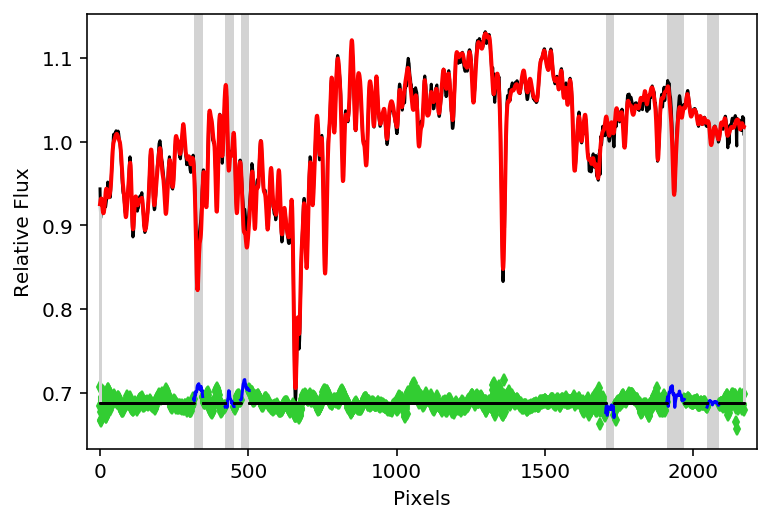

In [42]:

file_name = gal_name+"_data/"+gal_name+"center.fits"

lum_g_bol = ppxf_L_tot(file=file_name, gal_mask_params=gal_mask, star_mask_params=star_mask, 
                       mask=True, redshift=z, vel=gal_vel, dist_mod=dM)



In [44]:
lum_g_bol

12427593338.850716

In [24]:
#### FCC167 - 14076783324.737617
#### FCC219 - 12927602251.533566, 12546563984.934278
#### FCC161 - 7752216990.696291
#### FCC147 - 4959958598.278064
#### FCC193 - 4517220015.180022
#### FCC083 - 4460422745.658849
#### FCC249 - 2262353464.011233 - no mask  3070607923.9227934 , 2581155549.593469
#### FCC310 - 2926851406.531234, 2772415956.6301103
#### FCC277 - 1709225142.8519616
#### FCC255 - 
#### FCC276 - 5875958963.091068


In [19]:
np.log10((N_PNe/23967716221.75508).astype(float))

-7.859372732723544

In [45]:
galaxy_df = pd.DataFrame(columns=("Galaxy", "PNe N", "PNLF N", "N err", "Lbol", "alpha2.5", "alpha2.5 err",
                                  "FUV", "FUV err", "NUV", "NUV err", "Vmag", "Vmag err", 
                                  "Rmag", "Rmag err", "Bmag", "Bmag err", "B-V", "sigma", "M/H", "Mg/Fe"))

F3D_galaxies = ["FCC083", "FCC147","FCC161", "FCC167","FCC193", "FCC219", "FCC249", "FCC276","FCC277", "FCC310" ]

galaxy_df["Galaxy"] = F3D_galaxies


# FCC083
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC083", "PNe N"]  = 63.
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC083", "PNLF N"] = 110.
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC083", "Lbol"]   = 4460422745.658849

# FCC147
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC147", "PNe N"]  = 64.
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC147", "PNLF N"] = 112.35
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC147", "Lbol"]   = 4959958598.278064

# FCC161
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC161", "PNe N"]  = 111.
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC161", "PNLF N"] = 188.93
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC161", "Lbol"]   = 7752216990.696291

# FCC167
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC167", "PNe N"]  = 111.
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC167", "PNLF N"] = 340.79
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC167", "Lbol"]   = 14518511676.15995#23_967_716_221.75508#13_714_384_869.259789#14_076_783_324.737617

# FCC184
#galaxy_df.loc[galaxy_df["Galaxy"]=="FCC184", "PNe N"]  = 68
#galaxy_df.loc[galaxy_df["Galaxy"]=="FCC184", "PNLF N"] = 206.58
#galaxy_df.loc[galaxy_df["Galaxy"]=="FCC184", "Lbol"]   = 

# FCC193
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC193", "PNe N"]  = 155.
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC193", "PNLF N"] = 190.
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC193", "Lbol"]   = 4_517_220_015.180022

# FCC219
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC219", "PNe N"]  = 72.
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC219", "PNLF N"] = 174.4
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC219", "Lbol"]   = 12_427_593_338.850716

# FCC249
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "PNe N"]  = 12.
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "PNLF N"] = 35.20
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "Lbol"]   = 2_581_155_549.593469

# FCC255
#galaxy_df.loc[galaxy_df["Galaxy"]=="FCC255", "PNe N"]  = 38.
#galaxy_df.loc[galaxy_df["Galaxy"]=="FCC255", "PNLF N"] = 71.15
#galaxy_df.loc[galaxy_df["Galaxy"]=="FCC255", "Lbol"]   = 

# FCC276
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC276", "PNe N"]  = 75.
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC276", "PNLF N"] = 154.22
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC276", "Lbol"]   = 5_875_958_963.091068

# FCC277
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC277", "PNe N"]  = 26.
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC277", "PNLF N"] = 50.92
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC277", "Lbol"]   = 1_709_225_142.8519616

# FCC310
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC310", "PNe N"]  = 45.
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC310", "PNLF N"] = 90.84
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC310", "Lbol"]   = 2_772_415_956.6301103

galaxy_df["N err"]  = (1/(galaxy_df["PNe N"]**(1/2)))*galaxy_df["PNLF N"]
galaxy_df["alpha2.5"] = np.log10((galaxy_df["PNLF N"]/galaxy_df["Lbol"]).astype(float))
galaxy_df["alpha2.5 err"] =  galaxy_df["alpha2.5"] - np.log10(((galaxy_df["PNLF N"]+galaxy_df["N err"])/galaxy_df["Lbol"]).astype(float))
galaxy_df["Rmag"] = np.array([10.84, 10.50, 10.47, 9.27, 10.69, 8.57, 12.07, 10.15, 12.34, 11.81])
galaxy_df["sigma"]  = np.array([103, 131, 96, 143, 95, 154, 104, 123, 80, 48])
galaxy_df["M/H"]   = np.array([-0.20, 0.04, -0.13, 0.09, -0.09, 0.14, -0.26, -0.25, -0.34, -0.30])
galaxy_df["Mg/Fe"] = np.array([0.26, 0.23, 0.20, 0.20, 0.13, 0.18, 0.24, 0.20, 0.11, 0.14])


# list of F3D target names
#F3D_galaxies = ["FCC167", "FCC219", "FCC161", "FCC147", "FCC193", "FCC083", "FCC249", "FCC277", "FCC276" ]

viz_Bai_15 = Vizier(columns=["AsyFUV", "e_AsyFUV", "AsyNUV", "e_AsyNUV", "Bmag", "e_Bmag", "B-V"])

F3D_tables_15 = []
for f in galaxy_df["Galaxy"].values:#F3D_galaxies:
    F3D_tables_15.append(viz_Bai_15.query_object(f, catalog="J/ApJS/220/6/uvgal"))

for i, t in enumerate(F3D_tables_15):
    if len(t) == 0:
        continue
    else:
        galaxy_df.loc[i, "FUV"] = t[0][0]["AsyFUV"]
        galaxy_df.loc[i, "FUV err"] = t[0][0]["e_AsyFUV"]
        galaxy_df.loc[i, "NUV"] = t[0][0]["AsyNUV"]
        galaxy_df.loc[i, "NUV err"] = t[0][0]["e_AsyNUV"]
        galaxy_df.loc[i, "Bmag"] = t[0][0]["Bmag"]
        galaxy_df.loc[i, "Vmag err"] = t[0][0]["e_Bmag"]
        galaxy_df.loc[i, "B-V"] = t[0][0]["B-V"]

galaxy_df["Vmag"] = galaxy_df["Bmag"] - galaxy_df["B-V"]

galaxy_df.loc[galaxy_df["Galaxy"]=="FCC193", "FUV"]     = 18.66
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC193", "FUV err"] = 0.04
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC193", "NUV"]     = 16.73
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC193", "NUV err"] = 0.01

galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "FUV"]      = 19.796
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "FUV err"]  = 0.162
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "NUV"]      = 17.73
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "NUV err"]  = 0.051
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "Vmag"]     = 12.59
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "Vmag err"] = 0.08

galaxy_df.loc[galaxy_df["Galaxy"]=="FCC277", "FUV"]      = 20.283
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC277", "FUV err"]  = 0.229
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC277", "NUV"]      = 17.962
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC277", "NUV err"]  = 0.052
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC277", "Bmag"]     = 13.77

galaxy_df["FUV-V"]   = galaxy_df["FUV"] - galaxy_df["Vmag"]
galaxy_df["FUV-B"]   = galaxy_df["FUV"] - galaxy_df["Bmag"]
galaxy_df["FUV-NUV"] = galaxy_df["FUV"] - galaxy_df["NUV"]
galaxy_df["FUV-R"]   = galaxy_df["FUV"] - galaxy_df["Rmag"]

# save galaxy_df to csv for safe keeping
galaxy_df.to_csv("exported_data/galaxy_dataframe.csv")


##### Buzzoni data
list_of_B_g = ["205", "221", "224", "1316", "1344", "1399", "3031", "3115",
                 "3377", "3379", "3384", "4374", "4382", "4406", "4477", "4486",
                 "4594", "4649", "4697", "5128"]

Buzzoni_UV_m_V = [1.19,4.50, 3.51, 5.0, 2.05, 3.43, 3.86, 3.9, 3.55, 4.22, 3.72, 3.42, 2.04, 2.24, 3.41]
Buzzoni_log_a  = np.array([-6.88, -6.77, -6.94, -7.5, -6.75, -7.30, -6.8, -6.59, -6.43, -6.77, -6.42, -6.77, -6.7, -6.89, -7.16, -7.10, -6.66, -7.22, -6.82, -6.3])

Buzzoni_tables_15 = []
for g in list_of_B_g:
    Buzzoni_tables_15.append(viz_Bai_15.query_object("NGC"+g, catalog="J/ApJS/220/6/uvgal"))

B_FUV = np.ones(len(Buzzoni_tables_15))
B_FUV_err = np.ones_like(B_FUV)
B_Bmag = np.ones_like(B_FUV)
B_Vmag_err = np.ones_like(B_FUV)
B_B_m_V = np.ones_like(B_FUV)

for i, t in enumerate(Buzzoni_tables_15):
    if len(t) == 0:
        continue
    else:
        B_FUV[i]      = t[0][0]["AsyFUV"]
        B_FUV_err[i]  = t[0][0]["e_AsyFUV"]
        B_Bmag[i]     = t[0][0]["Bmag"]
        B_Vmag_err[i] = t[0][0]["e_Bmag"]
        B_B_m_V[i]    = t[0][0]["B-V"]

B_Vmag = B_Bmag - B_B_m_V

FUV_index_check = np.concatenate((np.where(B_FUV==1)[0], np.where(np.isnan(B_FUV))[0])) # get the indexes of 1's and nans
V_index_check = np.concatenate((np.where(B_Vmag==0)[0], np.where(np.isnan(B_Vmag))[0]))

# Corrections
B_FUV[1] = 15.84
B_FUV_err[1] = 0.03
B_Vmag[1] = 8.08
B_Vmag_err[1] = 0.05

B_FUV[4] = 17.841
B_FUV_err[4] = 0.053
B_Vmag[4] = 10.75
B_Vmag_err[4] = 0.02

B_FUV[8] = 16.30
B_FUV_err[8] = 0.05

B_FUV[12] = 15.18
B_FUV_err[12] = 0.01
B_Vmag[12] = 9.38
B_Vmag_err[12] = 0.08

B_FUV[17] = 15.15
B_FUV_err[17] = 0.01
B_Vmag[17] = 9.83
B_Vmag_err[17] = 0.08

B_FUV[18] = 16.57
B_FUV_err[18] = 0.02
B_Vmag[18] = 10.00
B_Vmag_err[18] = 0.02


B_FUV_m_V = B_FUV - B_Vmag
B_FUV_m_B = B_FUV - B_Bmag

/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: UserWarning: Warning: converting a masked element to nan.
/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:152: UserWarning: Warning: converting a masked element to nan.


/local/tspriggs/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:591: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/local/tspriggs/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/local/tspriggs/miniconda3/lib/python3.6/site-packages/matplotlib/text.py:1759: UserWarning: Warning: converting a masked element to nan.
  x = float(self.convert_xunits(x))
/local/tspriggs/miniconda3/lib/python3.6/site-packages/matplotlib/text.py:813: UserWarning: Warning: converting a masked element to nan.
  x = float(self.convert_xunits(self._x))


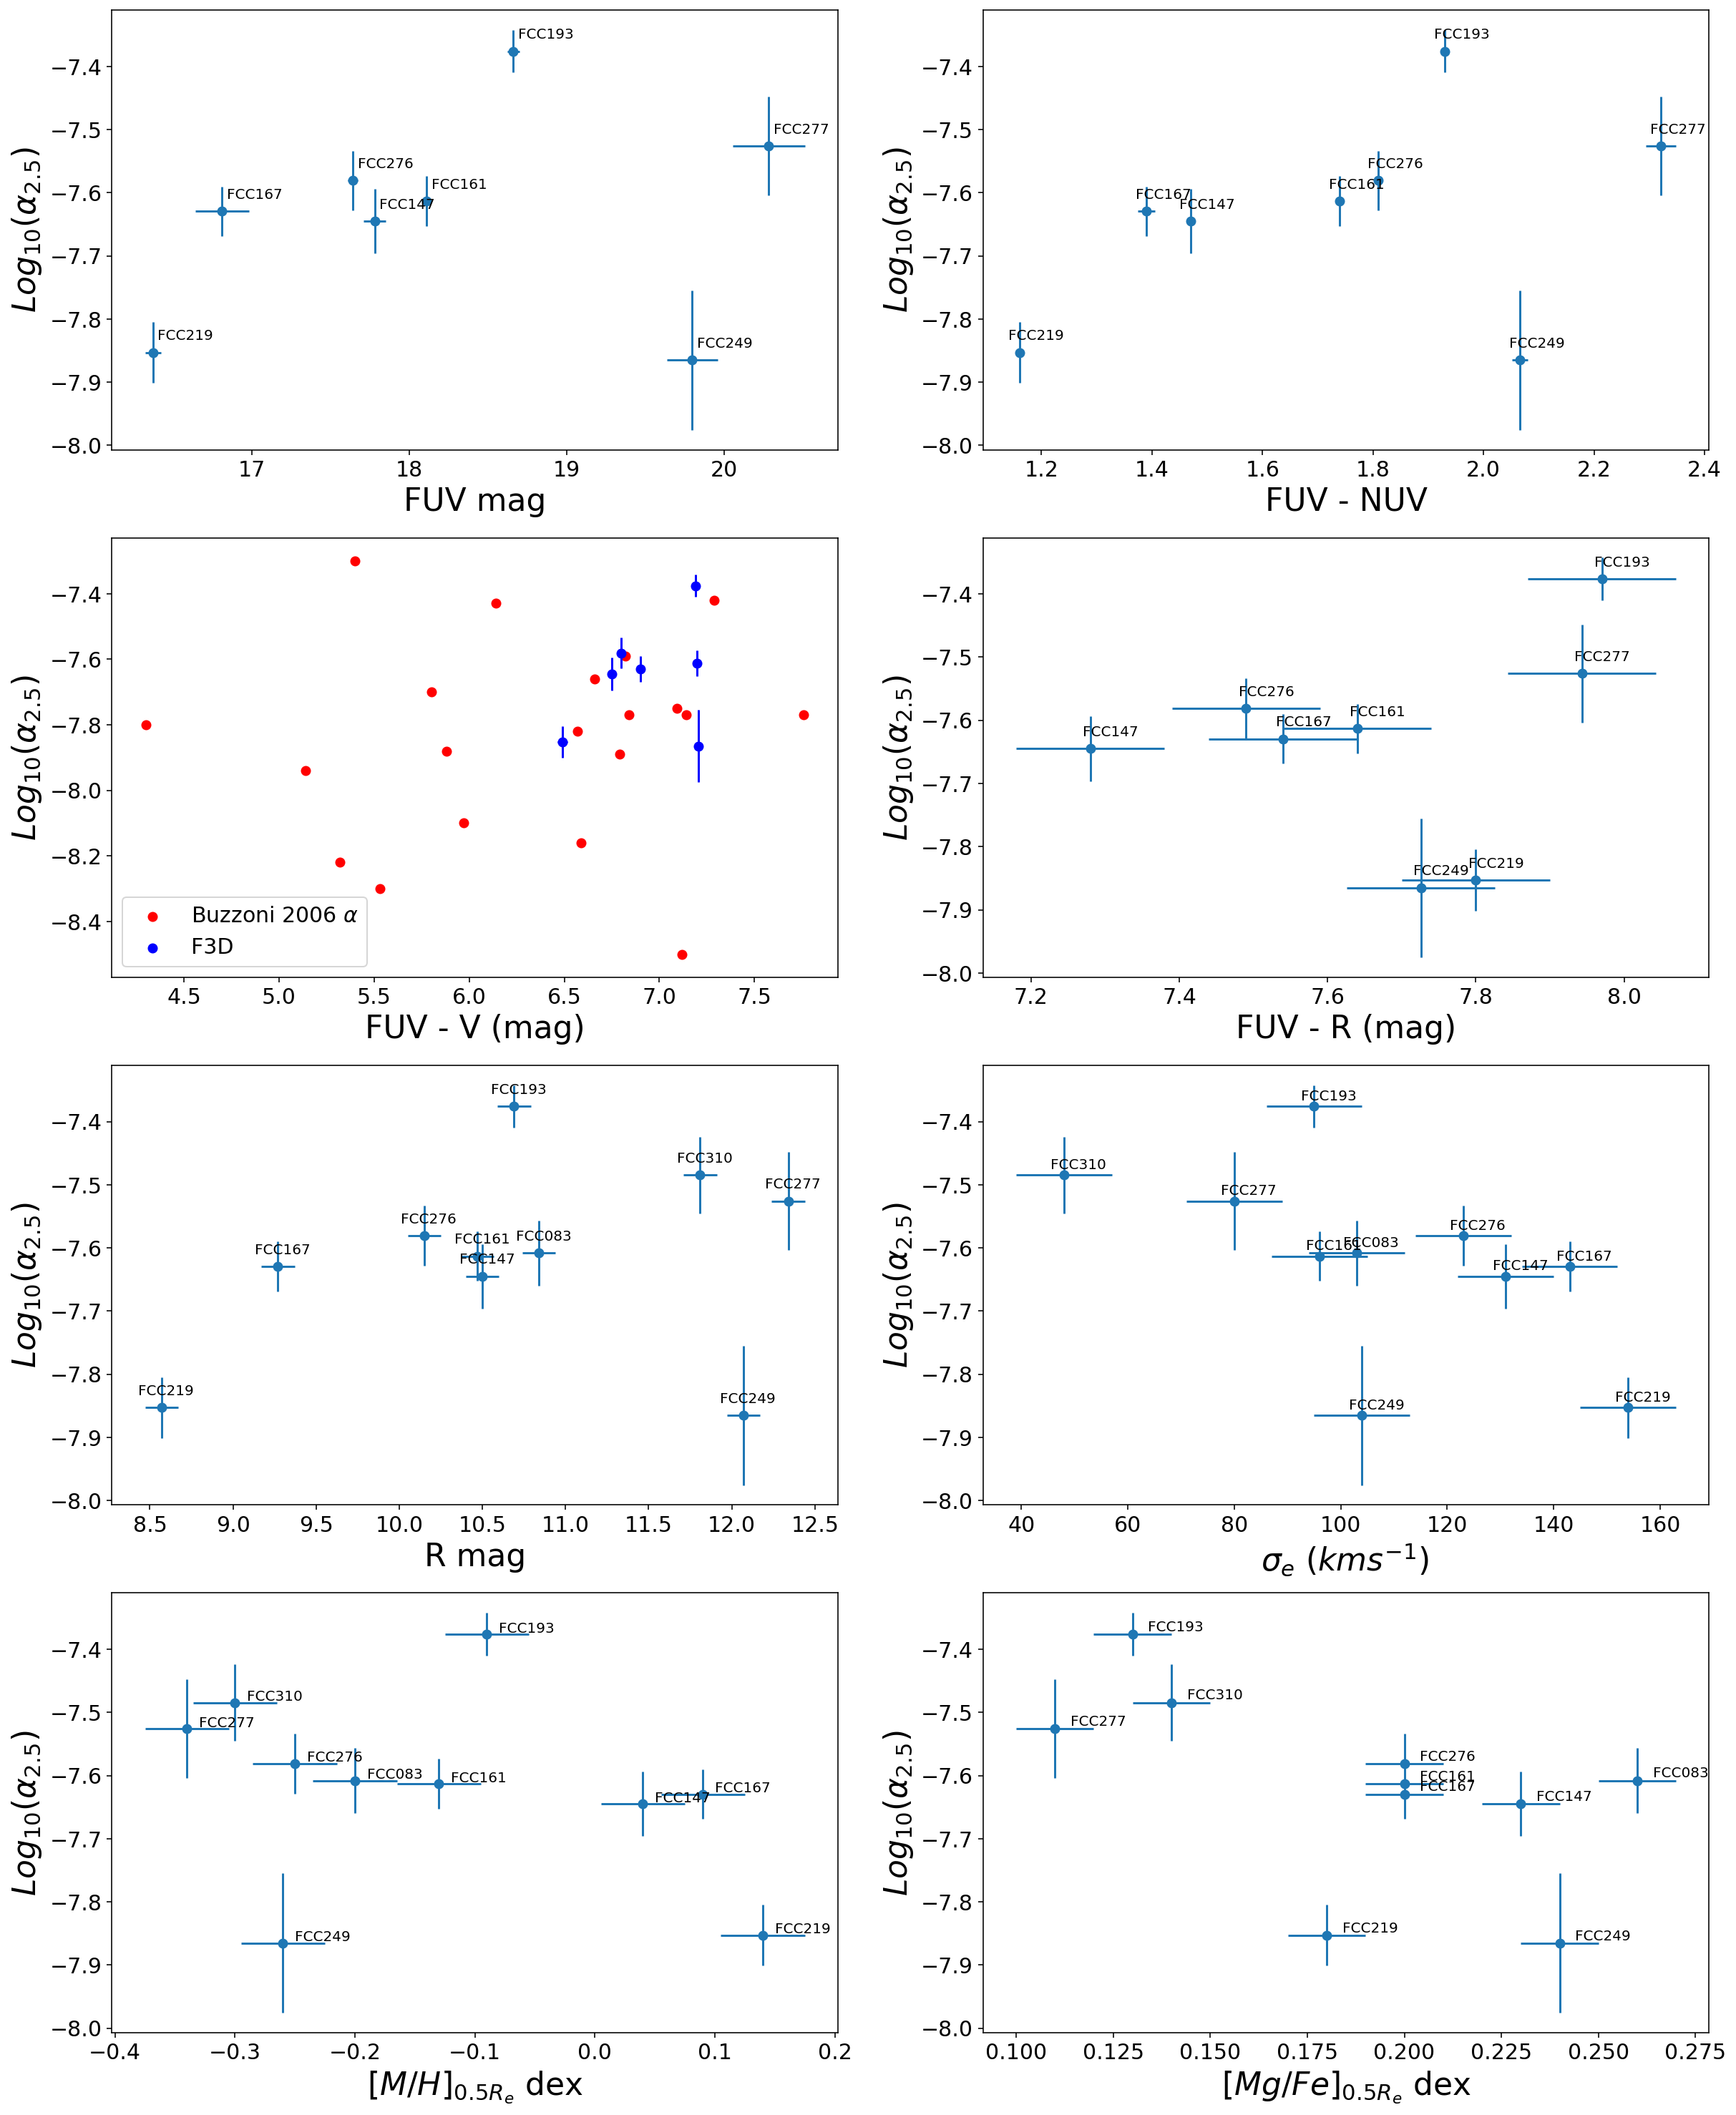

In [46]:
## Pandas version

f_size = 22
l_size = 15

plt.figure(figsize=(20,26))

ax1 = plt.subplot(4,2,1) # FUV
plt.scatter(galaxy_df["FUV"], galaxy_df["alpha2.5"])
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel("FUV mag", fontsize=f_size)
plt.errorbar(galaxy_df["FUV"], galaxy_df["alpha2.5"], xerr=galaxy_df["FUV err"], yerr=galaxy_df["alpha2.5 err"], ls="None")
plt.tick_params(labelsize=l_size)
#ax1.set_ylim(-8,-7)
#ax1 = plt.gca()
for i, name in enumerate(galaxy_df["Galaxy"]):
    ax1.annotate(name, (galaxy_df["FUV"][i]+0.03, galaxy_df["alpha2.5"][i]+0.02), color="black", size=10)


ax2 = plt.subplot(4,2,2) # FUV - NUV
plt.scatter(galaxy_df["FUV-NUV"], galaxy_df["alpha2.5"])
plt.errorbar(galaxy_df["FUV-NUV"], galaxy_df["alpha2.5"], xerr=(galaxy_df["FUV err"]**2+galaxy_df["NUV err"]**2)**1/2, yerr=galaxy_df["alpha2.5 err"], ls="None")
#plt.errorbar(B_FUV_m_V, Buzzoni_log_a-1, xerr=B_Vmag_err+B_FUV_err, yerr=0.08, c="r", ls="None", label=None)
plt.xlabel("FUV - NUV", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.tick_params(labelsize=l_size)
#plt.ylim(-8,-7)
for i, name in enumerate(galaxy_df["Galaxy"]):
    ax2.annotate(name, (galaxy_df["FUV-NUV"][i]-0.02,  galaxy_df["alpha2.5"][i]+0.02), color="black", size=10)


ax3 = plt.subplot(4,2,3) # FUV - V
plt.scatter(B_FUV_m_V, Buzzoni_log_a-1, c="r", label=r"Buzzoni 2006 $\alpha$")
plt.scatter(galaxy_df["FUV-V"], galaxy_df["alpha2.5"], c="b", label="F3D")
plt.errorbar(galaxy_df["FUV-V"], galaxy_df["alpha2.5"], xerr=(galaxy_df["NUV err"]**2+galaxy_df["Vmag err"]**2)**1/2, yerr=galaxy_df["alpha2.5 err"], c="b", ls="None")
#plt.errorbar(B_FUV_m_V, Buzzoni_log_a-1, xerr=B_Vmag_err+B_FUV_err, yerr=0.08, c="r", ls="None", label=None)
plt.xlabel("FUV - V (mag)", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.legend(fontsize=l_size)
#plt.xlim(4,)
ax3.tick_params(labelsize=l_size)



ax4 = plt.subplot(4,2,4) # FUV - R
plt.scatter(galaxy_df["FUV-R"], galaxy_df["alpha2.5"])
plt.errorbar(galaxy_df["FUV-R"], galaxy_df["alpha2.5"], xerr=0.1, yerr=galaxy_df["alpha2.5 err"], ls="None")
plt.xlabel("FUV - R (mag)", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.tick_params(labelsize=l_size)
#plt.ylim(-8,-7)
for i, name in enumerate(galaxy_df["Galaxy"]):
    ax4.annotate(name, (galaxy_df["FUV-R"][i]-0.01, galaxy_df["alpha2.5"].loc[i]+0.02), color="black", size=10)
    
# Rmag vs alpha
ax5 = plt.subplot(4,2,5)
plt.scatter(galaxy_df["Rmag"], galaxy_df["alpha2.5"])
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel("R mag", fontsize=f_size)
plt.errorbar(galaxy_df["Rmag"], galaxy_df["alpha2.5"], xerr=0.1, yerr=galaxy_df["alpha2.5 err"], ls="None")
plt.tick_params(labelsize=l_size)
#plt.ylim(-8,-7)
for i, name in enumerate(galaxy_df["Galaxy"]):
    ax5.annotate(name, (galaxy_df["Rmag"][i]-0.14, galaxy_df["alpha2.5"][i]+0.02), color="black", size=10)
    
ax6 = plt.subplot(4,2,6)
plt.scatter(galaxy_df["sigma"], galaxy_df["alpha2.5"])
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel(r"$\sigma_{e} \ (km s^{-1})$ ", fontsize=f_size)
plt.errorbar(galaxy_df["sigma"], galaxy_df["alpha2.5"], xerr=9.0, yerr=galaxy_df["alpha2.5 err"], ls="None")
plt.tick_params(labelsize=l_size)
for i, name in enumerate(galaxy_df["Galaxy"]):
    ax6.annotate(name, (galaxy_df["sigma"][i]-2.5, galaxy_df["alpha2.5"][i]+0.01), color="black", size=10)
    
    
ax7 = plt.subplot(4,2,7) # M/H metallicity
plt.scatter(galaxy_df["M/H"], galaxy_df["alpha2.5"])
plt.errorbar(galaxy_df["M/H"], galaxy_df["alpha2.5"], xerr=0.035, yerr=galaxy_df["alpha2.5 err"], ls="None")
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel(r"$[M/H]_{0.5R_{e}}$ dex", fontsize=f_size)
plt.tick_params(labelsize=l_size)
for i, name in enumerate(galaxy_df["Galaxy"]):
    ax7.annotate(name, (galaxy_df["M/H"][i]+0.01, galaxy_df["alpha2.5"][i]+0.003), color="black", size=10)
    
ax8 = plt.subplot(4,2,8)
plt.scatter(galaxy_df["Mg/Fe"], galaxy_df["alpha2.5"])
plt.errorbar(galaxy_df["Mg/Fe"], galaxy_df["alpha2.5"], xerr=0.01, yerr=galaxy_df["alpha2.5 err"], ls="None")
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel(r"$[Mg/Fe]_{0.5R_{e}}$ dex", fontsize=f_size)
plt.tick_params(labelsize=l_size)
for i, name in enumerate(galaxy_df["Galaxy"]):
    ax8.annotate(name, (galaxy_df["Mg/Fe"][i]+0.004, galaxy_df["alpha2.5"][i]+0.005), color="black", size=10)
    
#plt.savefig("Plots/Pandas_alpha_comparison_plots.pdf", bbox_inches='tight')
#plt.savefig("Plots/Pandas_alpha_comparison_plots.png", bbox_inches='tight')


In [30]:
pd.set_option('display.max_columns', 100)


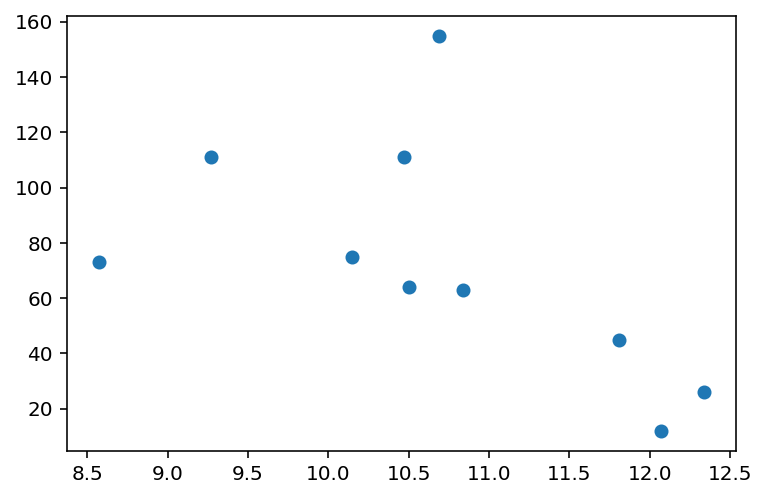

In [35]:
plt.scatter(galaxy_df["Rmag"], galaxy_df["PNe N"])

In [36]:
galaxy_df

Galaxy PNe N  PNLF N    N err         Lbol  alpha2.5  alpha2.5 err     FUV  \
0  FCC083    63     110  13.8587  4.46042e+09 -7.607983     -0.051534      --   
1  FCC147    64  112.35  14.0437  4.95996e+09 -7.644905     -0.051153   17.78   
2  FCC161   111  188.93  17.9324  7.75222e+09 -7.613125     -0.039381   18.11   
3  FCC167   111  340.79  32.3464  1.40768e+10 -7.616017     -0.039381   16.81   
4  FCC193   155     190  15.2612  4.51722e+09 -7.376118     -0.033553   18.66   
5  FCC219    73  177.54  20.7795  1.27873e+10 -7.857483     -0.048069   16.37   
6  FCC249    12    35.2  10.1614  2.58116e+09 -7.865272     -0.110143  19.796   
7  FCC276    75  154.22  17.8078  5.87596e+09 -7.580938     -0.047458   17.64   
8  FCC277    26   50.92  9.98623  1.70923e+09 -7.525911     -0.077773  20.283   
9  FCC310    45   90.84  13.5416  2.77242e+09 -7.484581     -0.060347     NaN   

  FUV err     NUV NUV err   Vmag Vmag err   Rmag Rmag err   Bmag Bmag err  \
0      --   16.53     0.1  11.51     0.14  10.84      NaN  12.38      NaN   
1    0.07   16.31    0.03  11.03     0.19  10.50      NaN  11.94      NaN   
2    0.03   16.37    0.02  10.91     0.16  10.47      NaN  11.79      NaN   
3    0.17   15.42    0.05   9.91      0.1   9.27      NaN  10.83      NaN   
4    0.04   16.73    0.01  11.47     0.12  10.69      NaN  12.38      NaN   
5    0.05   15.21    0.03   9.88     0.23   8.57      NaN  10.84      NaN   
6   0.162   17.73   0.051  12.59     0.08  12.07      NaN    NaN      NaN   
7    0.03   15.83    0.11  10.84     0.18  10.15      NaN  11.74      NaN   
8   0.229  17.962   0.052     --     0.25  12.34      NaN  13.77      NaN   
9     NaN     NaN     NaN    NaN      NaN  11.81      NaN    NaN      NaN   

    B-V  sigma   M/H  Mg/Fe  FUV-V  FUV-B FUV-NUV  FUV-R  
0  0.87    103 -0.20   0.26     --     --      --     --  
1  0.91    131  0.04   0.23   6.75   5.84    1.47   7.28  
2  0.88     96 -0.13   0.20    7.2   6.32    1.74   7.64  
3  0.92    143  0.09   0.20    6.9   5.98    1.39   7.54  
4  0.91     95 -0.09   0.13   7.19   6.28    1.93   7.97  
5  0.96    154  0.14   0.18   6.49   5.53    1.16    7.8  
6   NaN    104 -0.26   0.24  7.206    NaN   2.066  7.726  
7   0.9    123 -0.25   0.20    6.8    5.9    1.81   7.49  
8    --     80 -0.34   0.11     --  6.513   2.321  7.943  
9   NaN     48 -0.30   0.14    NaN    NaN     NaN    NaN